In [1]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import time
import pickle
import networkx as nx
import geopandas as gpd
from Adjoint_system import *
from State_system import *
%load_ext autoreload
%autoreload 2

### Load data

In [2]:
commute_path = 'V_data/Commute.csv'
covid_path = 'V_data/Covid.csv'
travel_path = 'V_data/Transport_data.csv'
kpa_path = 'V_data/Kpa_rate.csv'
#bed_path = '/Users/liuyang/Data/Input_data3/region_bed_count.csv'

In [3]:
name_path = 'V_data/Region_code.csv'
name = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(name_path, newline='') as name_f:
    name_reader = csv.reader(name_f, delimiter= ' ', quotechar='|')
    next(name_reader, None)
    for row in name_reader:
        #print(row)
        (code, reg)=row[0].split(',')
        #print(dep, arr)
        name[int(code) ] = reg

In [4]:
sigma = {} #the dict to store the commuting rate data, {(residence, work): commute rate}
with open(commute_path, newline='') as com_f:
    com_reader = csv.reader(com_f, delimiter= ' ', quotechar='|')
    next(com_reader, None)
    for row in com_reader:
        (res, wor, rate)=row[0].split(',')
        sigma[(int(res), int(wor))] = float(rate)
for i in sigma:
    if i[0]==i[1]:
        sigma[i]=0

In [5]:
N_p = {} #the dict to store population data {area code: population}
N_0 = {}  # the dict to store the initial health state data {area code: [S,V, L, I_a, I_t, I_nt, R]}
with open(covid_path, newline='') as covid_f:
    covid_reader = csv.reader(covid_f, delimiter= ' ', quotechar='|')
    next(covid_reader, None)
    for row in covid_reader:
        (code, t_pop, S, V, L, I, R)=row[0].split(',')
        N_p[int(code)] = int(t_pop)
        N_0[int(code)]= [float(S),float(V), float(L),float(I),float(R)]

In [6]:
X = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(travel_path, newline='') as travel_f:
    travel_reader = csv.reader(travel_f, delimiter= ' ', quotechar='|')
    next(travel_reader, None)
    for row in travel_reader:
        (dep, arr, pcnt)=row[0].split(',')
        #print(dep, arr)
        X[(int(dep), int(arr))] = float(pcnt)*1000/365

In [7]:
kpa = {} # the dict to store the infection rate for different areas {area code: infection rate}
with open(kpa_path, newline='') as kpa_f:
    kpa_reader = csv.reader(kpa_f, delimiter= ' ', quotechar='|')
    next(kpa_reader, None)
    for row in kpa_reader:
        (code, kpa_j)=row[0].split(',')
        kpa[int(code)] = float(kpa_j)

In [8]:
vac_cnt_path = 'V_data/Vaccine_cnt.csv'

Vac_cnt = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(vac_cnt_path, newline='') as vac_cnt_f:
    vac_cnt_reader = csv.reader(vac_cnt_f, delimiter= ' ', quotechar='|')
    next(vac_cnt_reader, None)
    for row in vac_cnt_reader:
        list_vc=row[0].split(',')
        Vac_cnt[int(list_vc[0])] = [int(n)/7 for n in list_vc[1:]]

In [9]:
# actural vaccination rate by prefectures
with open('V_data/Beta_act.pkl', 'rb') as f:
    beta_a = pickle.load(f)
#actural transportation rate in country wide range from docomo data
with open('V_data/Tsp_rate.pkl', 'rb') as f:
    delta_a = pickle.load(f)
# actural vaccination data in Japan
with open('V_data/C_Beta_act.pkl', 'rb') as f:
    C_beta = pickle.load(f)

In [10]:
### OVT
# cost_sum   # total cost in each iteration 
# R_inf      # pandemic data in the optimal situation
# beta_b     # optimal vaccination rate by prefecture
# delta_b    # optimal transportation control

### OV
# beta_o     # optimal vaccination rate by prefecture
# cost_b     # total cost in each iteration 
# R_inf_b    # pandemic data in the optimal situation

### OT
# delta_o    # optimal transportation control
# cost_d     # total cost in each iteration 
# R_inf_d    # pandemic data in the optimal situation

In [11]:
with open('Results/OVT_cost.pkl', 'rb') as file:
    cost_sum = pickle.load(file)

with open('Results/OVT_infection_data.pkl', 'rb') as file:
    R_inf = pickle.load(file)

with open('Results/OVT_beta.pkl', 'rb') as file:
    beta_b = pickle.load(file)
    
with open('Results/OVT_delta.pkl', 'rb') as file:
    delta_b = pickle.load(file)
    
    
with open('Results/OV_cost.pkl', 'rb') as file:
    cost_b = pickle.load(file)
    
with open('Results/OV_infection_data.pkl', 'rb') as file:
    R_inf_b = pickle.load(file)
    
with open('Results/OV_beta.pkl', 'rb') as file:
    beta_o = pickle.load(file)
    
with open('Results/OT_delta.pkl', 'rb') as file:
    delta_o = pickle.load(file)
    
with open('Results/OT_cost.pkl', 'rb') as file:
    cost_d = pickle.load(file)
    
with open('Results/OT_infection_data.pkl', 'rb') as file:
    R_inf_d = pickle.load(file)

In [12]:
Z = {0: list(range(1, 48))}
p_t = 1
v = 1/7               # infection period
xi = 1/1.1            # latent period
tau = 3               # return rate of daily commuters
#r = 1                # ratio of infectiousness of asymptomatic person
eta = 3               # coefficient to change the daily contact
t_s = 1.8             # period of stay of tourists
gamma_s = 0.007       # infection rate of unvaccinated individuals
gamma_v =0.0002       # infection rate of vaccinated individuals
t_f = {(0,0): 0.5}
T = 180
V_c =1.2954*1000000000000/120/1000/2
T_p = sum(N_p[j] for j in N_p)
C_pre = {j: V_c*N_p[j]/T_p/sum(beta_a[j][t]**2 for t in range(len(beta_a[j]))) for j in N_p}
c_b = C_pre

beta_c_max = [max(C_beta[:t]) for t in range(1,len(C_beta)+1)]
beta_max = beta_c_max
del_min = 0.5
beta_min = 0.001
c_i = {j:2 for j in N_0}
c_v = 0.0413 # purchase cost
c_d = 500260

params = {'p_t':p_t, 'v':v, 'xi':xi, 'tau':tau, 'eta':eta, 't_s':t_s, 
          'gamma_s':gamma_s, 'gamma_v':gamma_v,  
          'c_v':c_v, 'c_i':c_i , 'c_b':c_b, 'c_d':c_d, 't_f':t_f, 'T':T}


### Transportation map

In [13]:
travel_path = 'V_data/Transport_data.csv'
name_path = 'V_data/Region_code.csv'

In [14]:
X = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(travel_path, newline='') as travel_f:
    travel_reader = csv.reader(travel_f, delimiter= ' ', quotechar='|')
    next(travel_reader, None)
    for row in travel_reader:
        (dep, arr, pcnt)=row[0].split(',')
        #print(dep, arr)
        X[(int(dep), int(arr))] = float(pcnt)*1000/365

In [15]:
name = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(name_path, newline='') as name_f:
    name_reader = csv.reader(name_f, delimiter= ' ', quotechar='|')
    next(name_reader, None)
    for row in name_reader:
        #print(row)
        (code, reg)=row[0].split(',')
        #print(dep, arr)
        name[int(code) ] = reg

### Figures

In [16]:
### defalt colors in plots
pcolor = {'real':'tab:blue', 'base': 'tab:orange', 'OVT': 'tab:green', 'OV':'tab:red', 'OT':'tab:brown'}

#### Real transportation and vaccination rate

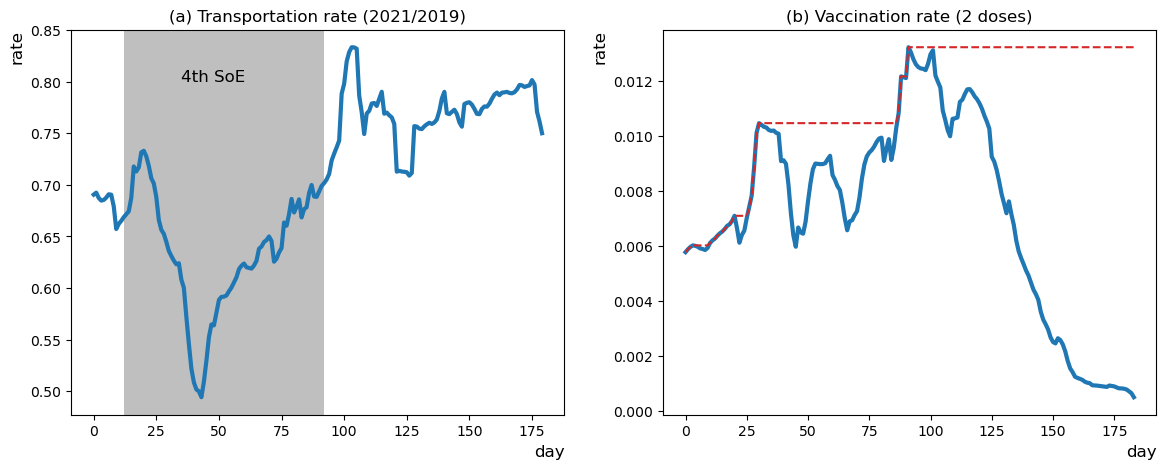

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(delta_a,linewidth = 3,  label='real situation', color=pcolor['real'])
plt.axvspan(xmin=12, xmax=92, linestyle='',color='grey', alpha=0.5)


#plt.text(20, 0.78 , '1', color='black', fontsize=12)
#plt.text(40, 0.78 , '5', color='black', fontsize=12)
#plt.text(50, 0.78 , '12', color='black', fontsize=12)
#plt.text(70, 0.78 , '18', color='black', fontsize=12)
plt.text(35, 0.8 , '4th SoE', color='black', fontsize=12)
plt.title('(a) Transportation rate (2021/2019)')
plt.xlabel('day', loc='right',fontsize = 12)
plt.ylabel('rate', loc='top',fontsize = 12)
plt.subplot(1,2,2)
plt.plot(C_beta,linewidth=3, label='real situation', color=pcolor['real'])
plt.plot(beta_c_max, linestyle='--', label='max vac rate', color = 'tab:red')
plt.title('(b) Vaccination rate (2 doses)')
plt.xlabel('day', loc='right',fontsize = 12)
plt.ylabel('rate', loc='top',fontsize = 12)
plt.show()

#### Convergence performance

Text(1, 0, 'Iterations')

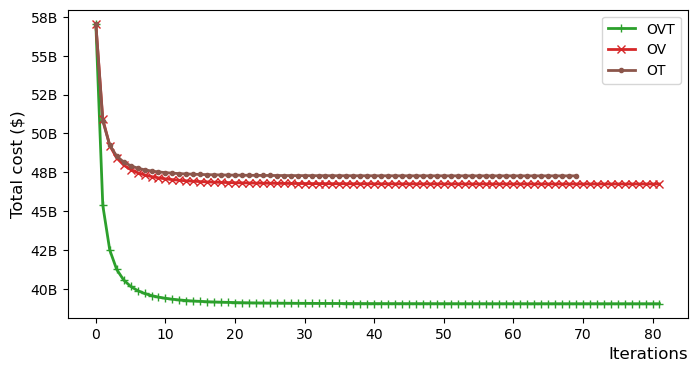

In [18]:
cost_both = [cost_sum[i]*1000 for i in cost_sum]
cost_vac = [cost_b[i]*1000 for i in cost_b]
cost_tra = [cost_d[i]*1000 for i in cost_d]

def format_ticks(value, pos):
    if value == max(cost_both):
        return '100M'
    else:
        return f'{value / 1e9:.0f}B'


plt.figure(figsize=(8,4))
plt.plot(cost_both,  marker='+', linewidth=2, label='OVT', color=pcolor['OVT'])
plt.plot(cost_vac,  marker='x', linewidth=2, label ='OV', color=pcolor['OV'])
plt.plot(cost_tra,  marker='.', linewidth=2, label='OT', color=pcolor['OT'])
#plt.hlines(cost,0, 85, linestyle='--',  linewidth=2, label='optimize T')
plt.legend()
#plt.title('Convergence performance')
plt.ylabel('Total cost ($)',fontsize = 12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
plt.xlabel('Iterations', loc='right',fontsize = 12)

In [19]:
### cost reduction in each scenario
print('OVT:',cost_both[0], 1- cost_both[-1]/cost_both[0])
print('OV:',cost_vac[0],  1- cost_vac[-1]/cost_vac[0])
print('OT:',cost_tra[0],  1- cost_tra[-1]/cost_tra[0])

OVT: 57059096485.94353 0.31566856310751135
OV: 57059096485.94353 0.18068165442956352
OT: 57059096485.94353 0.17150479385050388


#### Transportation control (Country)

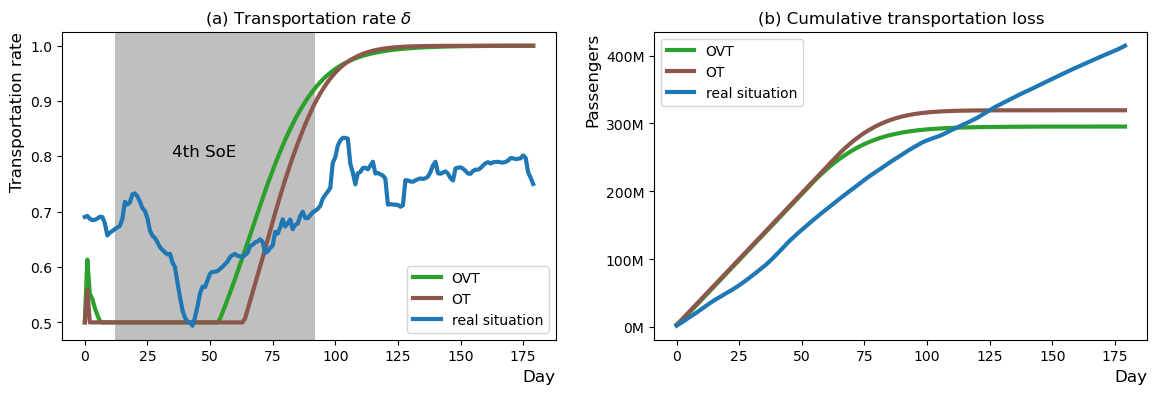

In [21]:

def format_ticks(value, pos):
    if value == max(Tloss_a):
        return '100M'
    else:
        return f'{value / 1e6:.0f}M'


X_sum = sum(X[l] for l in X)

Tloss_b = [X_sum*(1-delta_b[t]) for t in range(180)]
Tloss_o = [X_sum*(1-delta_o[t]) for t in range(180)]
Tloss_a = [X_sum*(1-delta_a[t]) for t in range(180)]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

plt.plot(delta_b,linewidth = 3,  label='OVT', color=pcolor['OVT'])
plt.plot(delta_o,linewidth = 3,  label='OT', color=pcolor['OT'])
plt.plot(delta_a,linewidth = 3,  label='real situation', color=pcolor['real'])
plt.axvspan(xmin=12, xmax=92, linestyle='',color='grey', alpha=0.5)


#plt.text(20, 0.78 , '1', color='black', fontsize=12)
#plt.text(40, 0.78 , '5', color='black', fontsize=12)
#plt.text(50, 0.78 , '12', color='black', fontsize=12)
#plt.text(70, 0.78 , '18', color='black', fontsize=12)
plt.text(35, 0.8 , '4th SoE', color='black', fontsize=12)
plt.legend(loc='best')
plt.ylabel('Transportation rate', loc='top',fontsize = 12)
plt.xlabel('Day', loc='right',fontsize = 12)
plt.title(r'(a) Transportation rate $\delta$')

plt.subplot(1,2,2)
plt.plot([sum(Tloss_b[:t+1]) for t in range(180)],linewidth = 3,  label='OVT', color=pcolor['OVT'])
plt.plot([sum(Tloss_o[:t+1]) for t in range(180)],linewidth = 3,  label='OT', color=pcolor['OT'])
plt.plot([sum(Tloss_a[:t+1]) for t in range(180)],linewidth = 3,  label='real situation', color=pcolor['real'])
plt.legend(loc='best')
plt.ylabel('Passengers', loc='top',fontsize = 12)
plt.xlabel('Day', loc='right',fontsize = 12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
plt.title('(b) Cumulative transportation loss')
plt.show()

In [22]:
### the end day of transportation control of OVT and OT

for i in range(len(delta_b)):
    if delta_b[i] > 0.99:
        print('OVT', i)
        break
        
for i in range(len(delta_o)):
    if delta_o[i] > 0.99:
        print('OT', i)
        break

OVT 120
OT 115


In [23]:
sum(Tloss_b)-sum(Tloss_o)

-23972506.479150176

In [24]:
print('OVT/Real: ', sum(Tloss_b)/sum(Tloss_a))
print('OT/Real: ', sum(Tloss_o)/sum(Tloss_a))
print('OVT/OT: ', sum(Tloss_b)/sum(Tloss_o))

OVT/Real:  0.7130013906253628
OT/Real:  0.7708498596624509
OVT/OT:  0.9249549463984862


#### Vaccination control in country

In [25]:


### vaccination rate calculation
b_both = [sum(R_inf[j][0][t]*beta_b[j][t] for j in N_p)/sum(R_inf[j][0][t] for j in N_p ) for t in range(180)]
b_only = [sum(R_inf_b[j][0][t]*beta_o[j][t] for j in N_p)/sum(R_inf_b[j][0][t] for j in N_p ) for t in range(180)]
beta_c_max = [max(C_beta[:t]) for t in range(1,len(C_beta)+1)]

### calculate the cumulative vaccine dose count in both controlled situation
b_cnt_both = [sum(R_inf[j][0][t]*beta_b[j][t] for j in N_p) for t in range(180)]
vac_both_cumu = [sum(b_cnt_both[:t+1])*2 for t in range(180)]
### calculate the cumulative vaccine dose count in only vaccination controlled situation
b_cnt_only = [sum(R_inf_b[j][0][t]*beta_o[j][t] for j in N_p) for t in range(180)]
vac_only_cumu = [sum(b_cnt_only[:t+1])*2 for t in range(180)]
### calculate the cumulative vaccine dose count in real situation
vac_cnt_t = [sum(Vac_cnt[j][t] for j in N_p) for t in range(180)]
vac_cnt_cumu = [sum(vac_cnt_t[:t+1])*2 for t in range(180)]

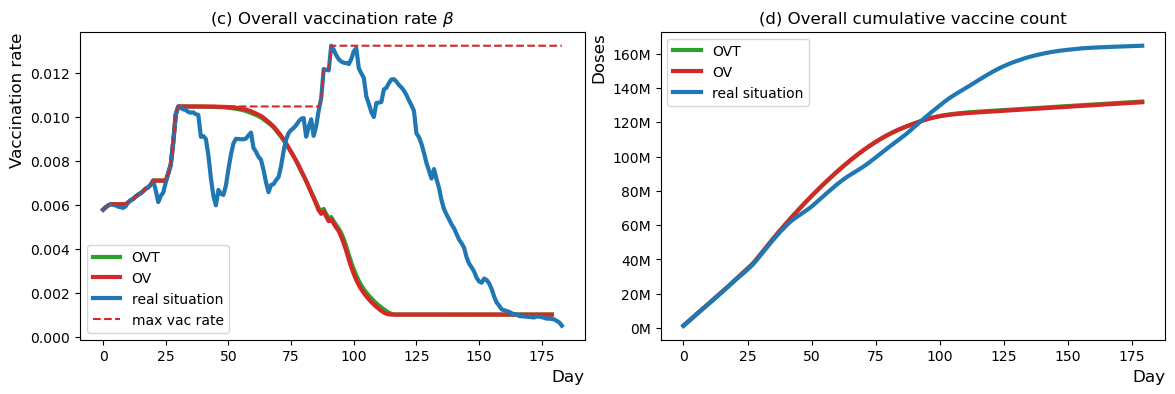

In [26]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(b_both,linewidth=3, label='OVT', color=pcolor['OVT'])
plt.plot(b_only,linewidth=3, label='OV', color=pcolor['OV'])
plt.plot(C_beta,linewidth=3, label='real situation', color=pcolor['real'])
plt.plot(beta_c_max, linestyle='--', label='max vac rate', color = 'tab:red')
plt.legend()
plt.title(r'(c) Overall vaccination rate $\beta$')
plt.xlabel('Day', loc='right',fontsize = 12)
plt.ylabel('Vaccination rate', loc='top',fontsize = 12)


plt.subplot(1,2, 2)
plt.plot(vac_both_cumu,  linewidth=3, label='OVT', color=pcolor['OVT'])
plt.plot(vac_only_cumu,  linewidth=3, label='OV', color=pcolor['OV'])
plt.plot(vac_cnt_cumu, linewidth=3, label='real situation', color=pcolor['real'])
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
#plt.text(0, 1.02, '100M', transform=plt.gca().transAxes, ha='left', va='bottom')
plt.xlabel('Day', loc='right',fontsize = 12)
plt.ylabel('Doses', loc='top',fontsize = 12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
plt.legend()
plt.title('(d) Overall cumulative vaccine count')
plt.subplots_adjust(wspace=0.15)
plt.show()

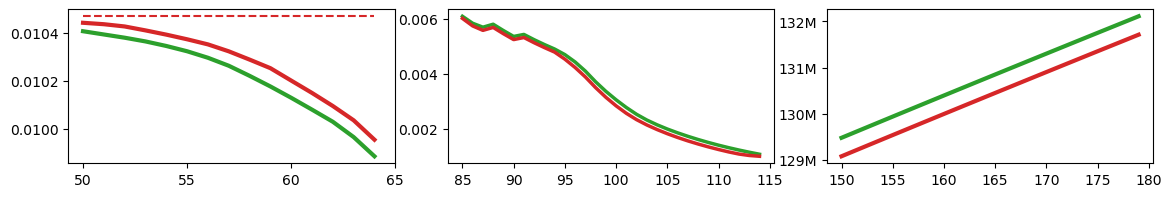

In [27]:
plt.figure(figsize=(14,2))
plt.subplot(1,3,1)
plt.plot(beta_c_max[50:65], linestyle='--', label='max vac rate', color = 'tab:red')
plt.plot(b_both[50:65],linewidth=3, label='OVT', color=pcolor['OVT'])
plt.plot(b_only[50:65],linewidth=3, label='OV', color=pcolor['OV'])
plt.xticks([0,5,10,15], [50, 55, 60, 65])

plt.subplot(1,3,2)
plt.plot(b_both[85:115],linewidth=2.5, label='OVT', color=pcolor['OVT'])
plt.plot(b_only[85:115],linewidth=2.5, label='OV', color=pcolor['OV'])
plt.xticks([0,5,10,15,20, 25, 30], [85, 90, 95, 100, 105, 110, 115])

plt.subplot(1,3,3)
plt.plot(vac_both_cumu[150:],  linewidth=3, label='OVT', color=pcolor['OVT'])
plt.plot(vac_only_cumu[150:],  linewidth=3, label='OV', color=pcolor['OV'])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
plt.xticks([0,5,10,15,20,25, 30], [150, 155, 160, 165, 170, 175, 180], fontsize=10)
plt.yticks(fontsize=10)
plt.subplots_adjust(wspace=0.16)
plt.show()

In [28]:
print('OVT/Real: ', vac_both_cumu[-1]/vac_cnt_cumu[-1])
print('OV/Real: ', vac_only_cumu[-1]/vac_cnt_cumu[-1])
print('OVT/OV: ', vac_both_cumu[-1]/vac_only_cumu[-1])

OVT/Real:  0.8021861981747841
OV/Real:  0.799768128516886
OVT/OV:  1.0030234633910484


#### Infection by prefecture

In [29]:
beta0 = beta_a
delta0 = delta_a
Vac_res = State_solution(N_p, N_0, sigma, X, kpa, Z, delta0, beta0, params)
R_inf0, cost0, L_s0, L_v0 = Vac_res.get_res()

Vac_res_b = State_solution(N_p, N_0, sigma, X, kpa, Z, delta0, beta_o, params)
R_inf_b, costb, L_sb, L_vb = Vac_res_b.get_res()

Vac_res_d = State_solution(N_p, N_0, sigma, X, kpa, Z, delta_o, beta0, params)
R_inf_d, costd, L_sd, L_vd = Vac_res_d.get_res()

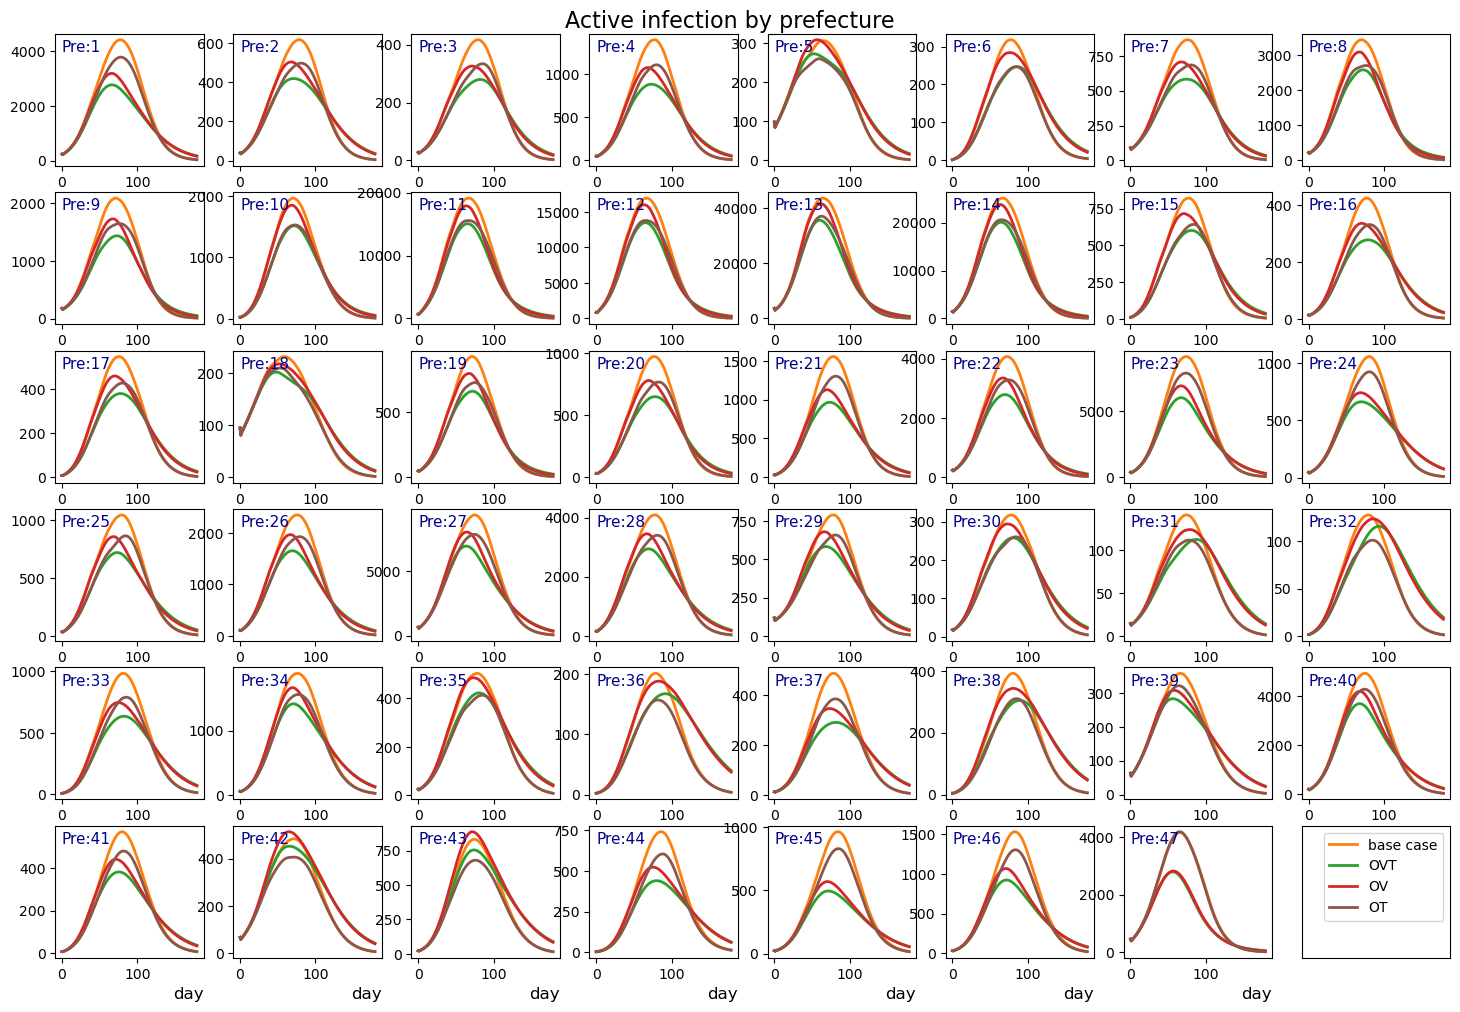

In [30]:
plt.figure(figsize=(18,12))
for n in Z[0]:
    plt.subplot(6,8,n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    plt.plot(R_inf0[n][3], linewidth = 2, label='base case', color=pcolor['base'])
    plt.plot(R_inf[n][3], linewidth = 2, label='OVT', color=pcolor['OVT'])
    plt.plot(R_inf_b[n][3], linewidth = 2, label='OV', color=pcolor['OV'])
    plt.plot(R_inf_d[n][3], linewidth = 2, label='OT', color=pcolor['OT'])
    max_i = max(max(R_inf0[n][3]), max(R_inf[n][3]), max(R_inf_b[n][3]), max(R_inf_d[n][3]))
    plt.text(0, max_i*0.9, 'Pre:{0}'.format(n), color='darkblue', fontsize=11)
    #plt.title(region_name[n], fontsize = 13)
    #plt.ylabel('Active infected', loc='top',fontsize = 12)
    plt.xlabel('day', loc='right',fontsize = 12)
    #plt.legend()
plt.subplot(6,8,48)
plt.plot([], linewidth = 2, label='base case', color=pcolor['base'])
plt.plot([], linewidth = 2, label='OVT', color=pcolor['OVT'])
plt.plot([], linewidth = 2, label='OV', color=pcolor['OV'])
plt.plot([], linewidth = 2, label='OT', color=pcolor['OT'])
plt.xticks([])  # Hide x labels
plt.yticks([])  # Hide y labels
plt.legend()
plt.suptitle('Active infection by prefecture', fontsize=16, y=0.9)
plt.show()

#### Vaccination by region

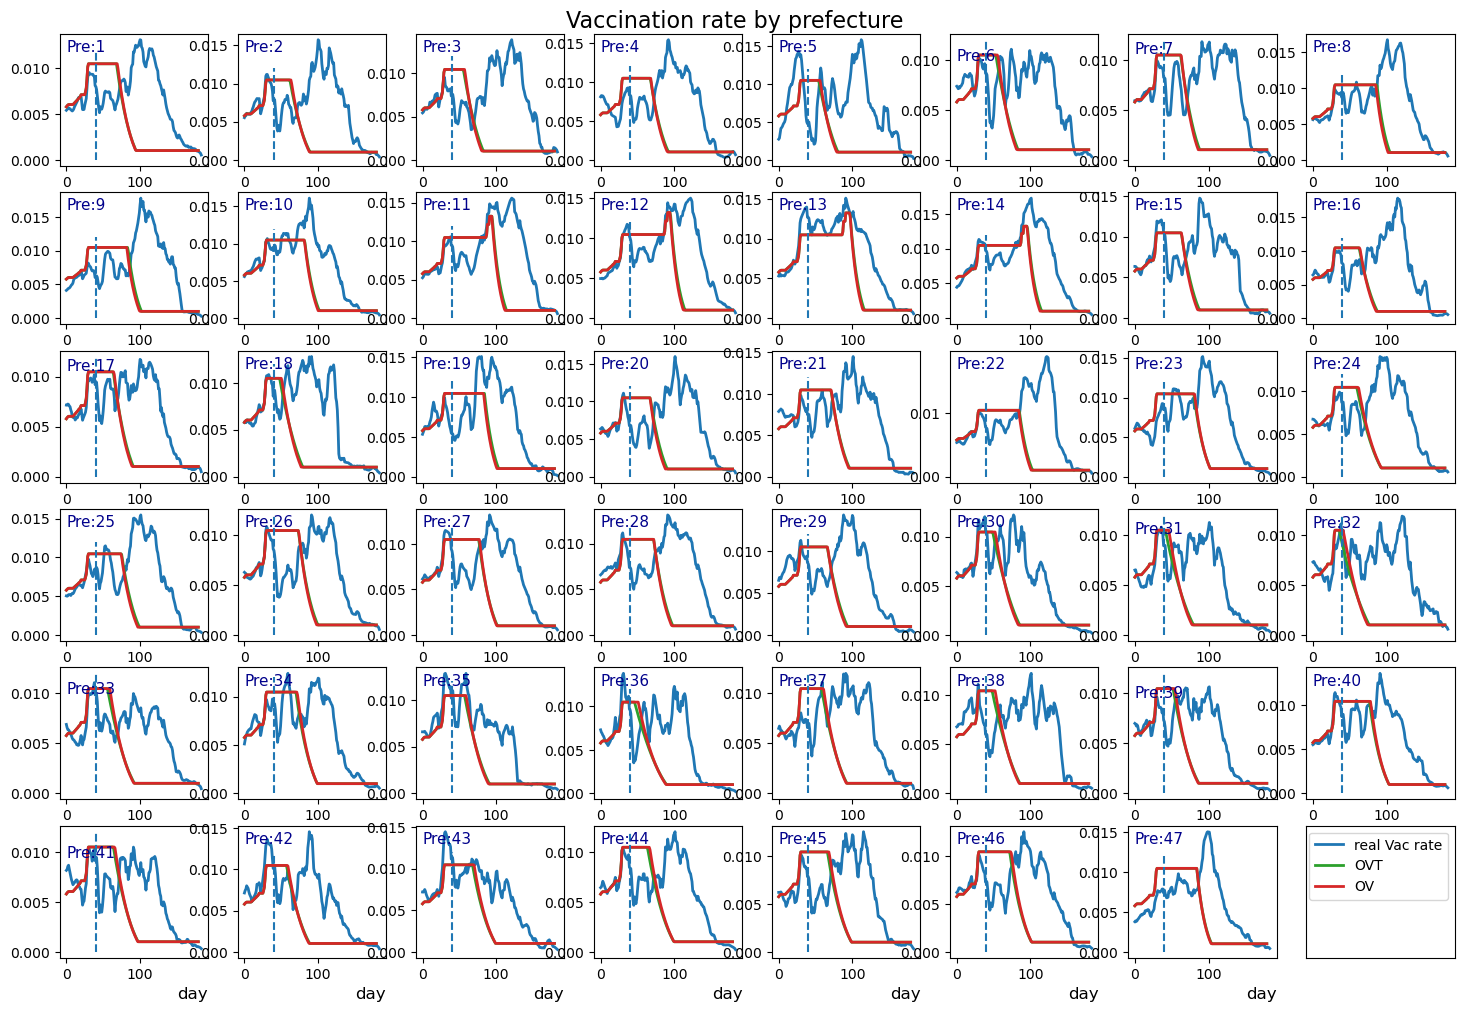

In [31]:
plt.figure(figsize=(18,12))
for n in Z[0]:
    plt.subplot(6,8,n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    plt.plot(beta_a[n], linewidth = 2, label='real vac rate', color=pcolor['real'])
    plt.plot(beta_b[n], linewidth = 2, label='OVT', color=pcolor['OVT'])
    plt.plot(beta_o[n], linewidth = 2, label='OV', color=pcolor['OV'])
    #max_i = max(max(R_inf0[n][3]), max(R_inf[n][3]), max(R_inf_b[n][3]), max(R_inf_d[n][3]))
    plt.text(0, max(beta_a[n])*0.9, 'Pre:{0}'.format(n), color='darkblue', fontsize=11)
    #plt.title(region_name[n], fontsize = 13)
    #plt.ylabel('Active infected', loc='top',fontsize = 12)
    plt.xlabel('day', loc='right',fontsize = 12)
    plt.vlines(40, 0, 0.012, linestyle='--')
    #plt.legend()
plt.subplot(6,8,48)
plt.plot([], linewidth = 2, label='real Vac rate', color=pcolor['real'])
plt.plot([], linewidth = 2, label='OVT', color=pcolor['OVT'])
plt.plot([], linewidth = 2, label='OV', color=pcolor['OV'])
plt.xticks([])  # Hide x labels
plt.yticks([])  # Hide y labels
plt.legend()
plt.suptitle('Vaccination rate by prefecture', fontsize=16, y=0.9)
plt.show()

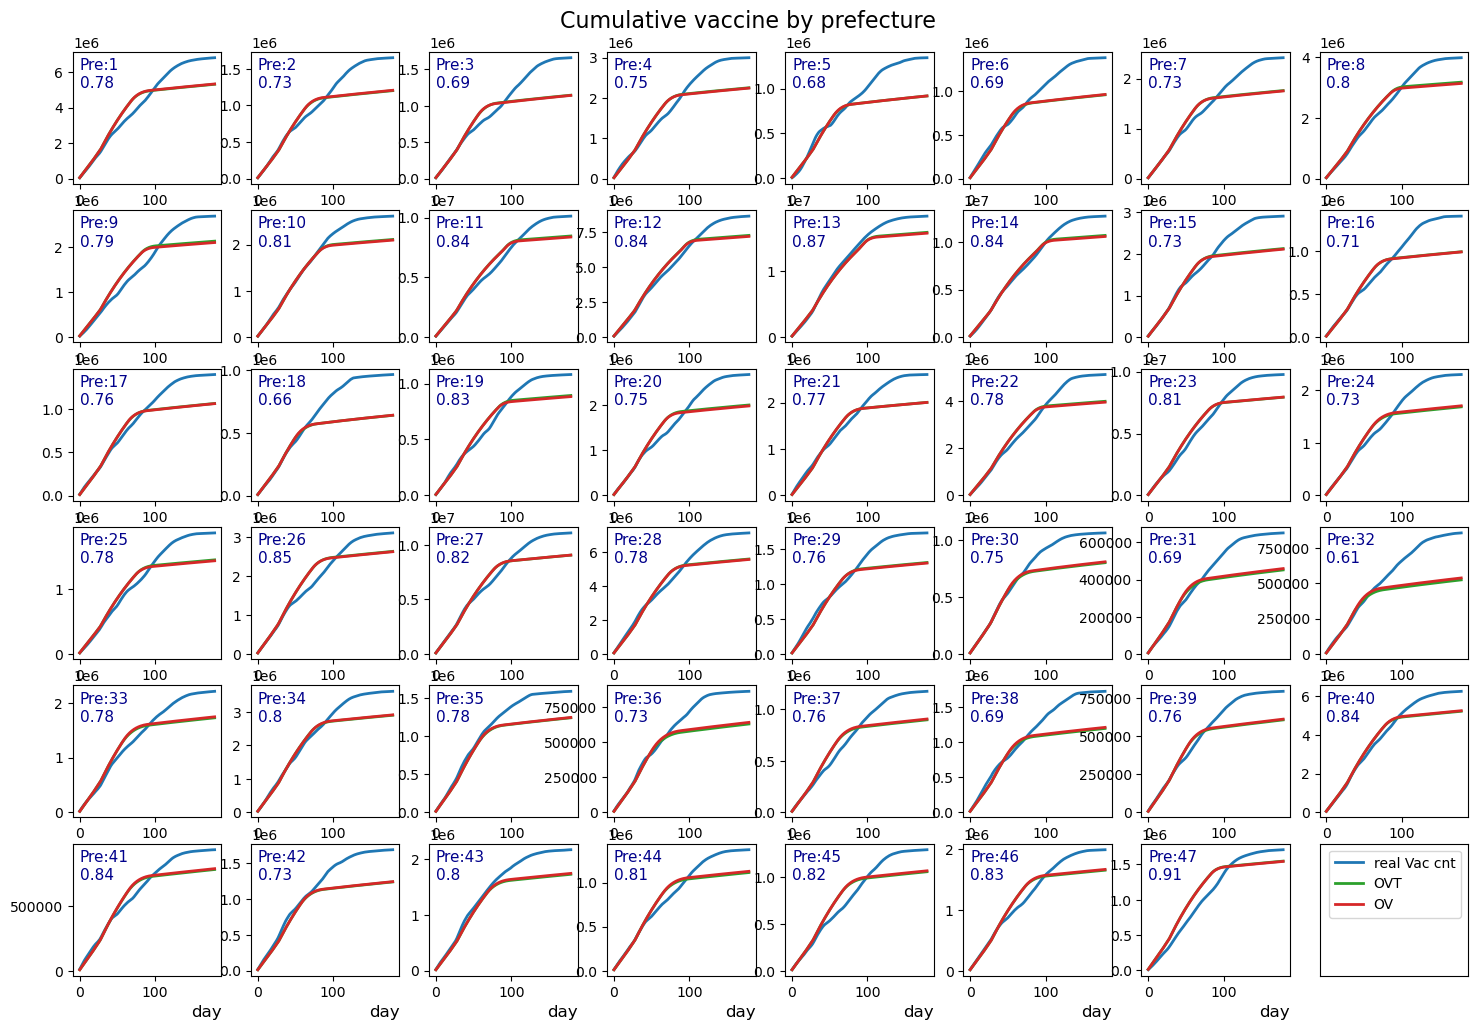

In [32]:
from matplotlib.ticker import StrMethodFormatter
Vac_cumu_real = {j: [sum(Vac_cnt[j][:t+1])*2 for t in range(180)] for j in N_p}

vac_ovt = {j: [R_inf[j][0][t]*beta_b[j][t] for t in range(180)] for j in N_p}
vac_ov = {j: [R_inf_b[j][0][t]*beta_o[j][t]  for t in range(180)] for j in N_p}
Vac_cumu_ovt = {j: [sum(vac_ovt[j][:t+1])*2 for t in range(180)] for j in N_p}
Vac_cumu_ov = {j: [sum(vac_ov[j][:t+1])*2 for t in range(180)] for j in N_p}

plt.figure(figsize=(18,12))
for n in Z[0]:
    plt.subplot(6,8,n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    plt.plot(Vac_cumu_real[n], linewidth = 2, label='real vac cnt', color=pcolor['real'])
    plt.plot(Vac_cumu_ovt[n], linewidth = 2, label='OVT', color=pcolor['OVT'])
    plt.plot(Vac_cumu_ov[n], linewidth = 2, label='OV', color=pcolor['OV'])
    #max_i = max(max(R_inf0[n][3]), max(R_inf[n][3]), max(R_inf_b[n][3]), max(R_inf_d[n][3]))
    plt.text(0, max(Vac_cumu_real[n])*0.9, 'Pre:{0}'.format(n), color='darkblue', fontsize=11)
    plt.text(0, max(Vac_cumu_real[n])*0.75, '{0}'.format(round(Vac_cumu_ovt[n][-1]/Vac_cumu_real[n][-1],2)), color='darkblue', fontsize=11)
    #plt.title(region_name[n], fontsize = 13)
    #plt.ylabel('Active infected', loc='top',fontsize = 12)
    plt.xlabel('day', loc='right',fontsize = 12)
    #plt.legend()
plt.subplot(6,8,48)
plt.plot([], linewidth = 2, label='real Vac cnt', color=pcolor['real'])
plt.plot([], linewidth = 2, label='OVT', color=pcolor['OVT'])
plt.plot([], linewidth = 2, label='OV', color=pcolor['OV'])
plt.xticks([])  # Hide x labels
plt.yticks([])  # Hide y labels
plt.legend()
plt.suptitle('Cumulative vaccine by prefecture', fontsize=16, y=0.915)
plt.show()

In [33]:
## total vaccine relocated
sum(abs(Vac_cumu_ovt[n][-1]-Vac_cumu_ov[n][-1]) for n in N_p)

914490.7009782771

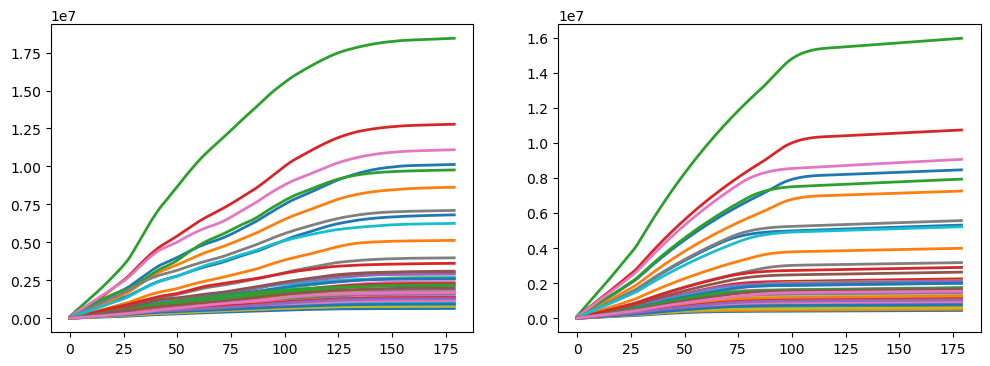

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for n in Z[0]:
    #n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    #plt.plot(Vac_cumu_real[n], linewidth = 2, label='real vac cnt')
    #plt.plot(Vac_cumu_ovt[n], linewidth = 2, label='OVT')
    plt.plot(Vac_cumu_real[n], linewidth = 2, label='OV')
    
plt.subplot(1,2,2)
for n in Z[0]:
    #n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    #plt.plot(Vac_cumu_real[n], linewidth = 2, label='real vac cnt')
    plt.plot(Vac_cumu_ovt[n], linewidth = 2, label='OVT')
    #plt.plot(Vac_cumu_ov[n], linewidth = 2, label='OV')
plt.show()

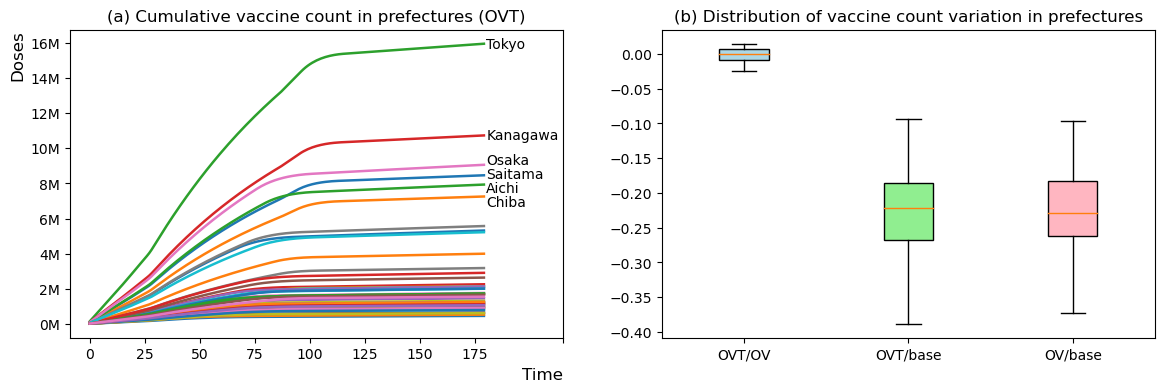

In [35]:
Vac_ovt_ov = [(Vac_cumu_ovt[n][-1]-Vac_cumu_ov[n][-1])/Vac_cumu_ov[n][-1] for n in Vac_cumu_ov]
Vac_ovt_base = [(Vac_cumu_ovt[n][-1]-Vac_cumu_real[n][-1])/Vac_cumu_real[n][-1] for n in Vac_cumu_real]
Vac_ov_base = [(Vac_cumu_ov[n][-1]-Vac_cumu_real[n][-1])/Vac_cumu_real[n][-1] for n in Vac_cumu_real]
#plt.boxplot(Vac_var)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
for n in Z[0]:
    #n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    #plt.plot(Vac_cumu_real[n], linewidth = 2, label='real vac cnt')
    plt.plot(Vac_cumu_ovt[n], linewidth = 1.8, label='OVT')
    #if Vac_cumu_ovt[n][-1] >0.6e7:
        #plt.text(180, Vac_cumu_ovt[n][-1]*0.99 , '{0}'.format(name[n]), color='black', fontsize=10)
    #plt.plot(Vac_cumu_ov[n], linewidth = 2, label='OV')
plt.text(180, 1.57e7 , 'Tokyo', color='black', fontsize=10)
plt.text(180, 1.05e7 , 'Kanagawa', color='black', fontsize=10)
plt.text(180, 0.91e7 , 'Osaka', color='black', fontsize=10)
plt.text(180, 0.83e7 , 'Saitama', color='black', fontsize=10)
plt.text(180, 0.75e7 , 'Aichi', color='black', fontsize=10)
plt.text(180, 0.67e7 , 'Chiba', color='black', fontsize=10)
#plt.axvspan(xmin=-15, xmax=5, ymin=0, ymax=1,linestyle='',color='grey', alpha=0.5)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 215], [0, 25, 50, 75, 100, 125, 150, 175, ''])
plt.title('(a) Cumulative vaccine count in prefectures (OVT)')
plt.xlabel('Time', loc='right',fontsize = 12)
plt.ylabel('Doses', loc='top',fontsize = 12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
plt.subplot(1,2,2)
colors = ['lightblue', 'lightgreen', 'lightpink']
#plt.boxplot([Vac_ovt_base, Vac_ov_base, Vac_ovt_ov], vert=False, patch_artist=True, widths=0.4)
# Customize the box colors
for patch, color in zip(plt.boxplot([Vac_ovt_ov, Vac_ovt_base, Vac_ov_base], vert=True, patch_artist=True)['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
plt.xticks([1, 2, 3], [ 'OVT/OV', 'OVT/base', 'OV/base'])
plt.title('(b) Distribution of vaccine count variation in prefectures')

# Show the plot
plt.show()

In [36]:
OVT_dict = {name[i]: Vac_ovt_ov[i-1] for i in name}

In [37]:
print(max(Vac_ovt_ov), min(Vac_ovt_ov))
print( min(Vac_ovt_base))
print(min(Vac_ov_base))

0.014601723951181806 -0.025160929817721292
-0.3881076096678705
-0.37231445779279676


#### Active infection in country

In [38]:
covid_real = '/Users/liuyang/Data/Covid data/Covid-actual.csv'

Pref_covid = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(covid_real, newline='') as cov_f:
    cov_reader = csv.reader(cov_f, delimiter= ' ', quotechar='|')
    next(cov_reader, None)
    for row in cov_reader:
        list_cov=row[0].split(',')
        Pref_covid[list_cov[0]] = [int(n) for n in list_cov[1:]]

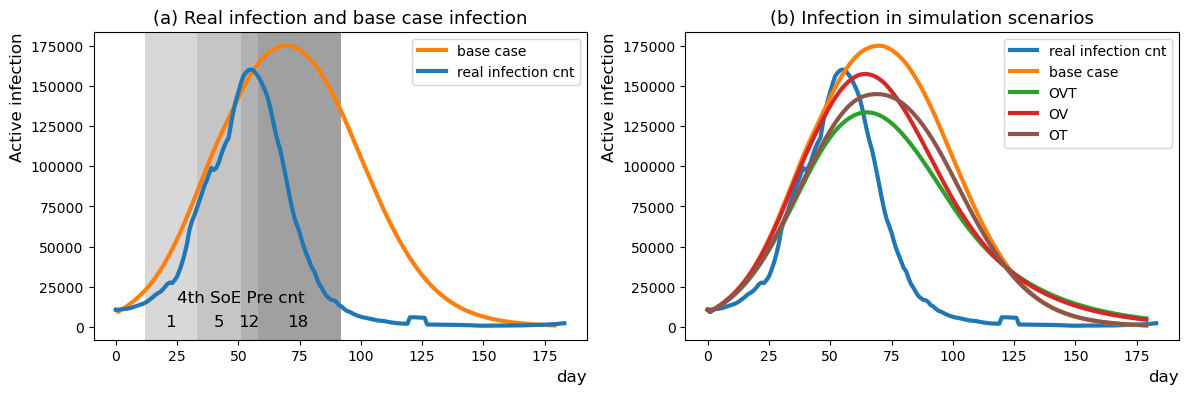

In [39]:
C_inf = [sum(R_inf[j][3][t] for j in N_0) for t in range(180)]
C_inf0 = [sum(R_inf0[j][3][t] for j in N_0) for t in range(180)]
C_inf_b = [sum(R_inf_b[j][3][t] for j in N_0) for t in range(180)]
C_inf_d = [sum(R_inf_d[j][3][t] for j in N_0) for t in range(180)]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(C_inf0, linewidth = 3,label='base case', color=pcolor['base'])
plt.plot(Pref_covid['0'], linewidth = 3, label='real infection cnt', color=pcolor['real'])

plt.axvspan(xmin=12, xmax=33, linestyle='',color='grey', alpha=0.3)
plt.axvspan(xmin=33, xmax=51, linestyle='',color='grey', alpha=0.45)
plt.axvspan(xmin=51, xmax=58, linestyle='',color='grey', alpha=0.6)
plt.axvspan(xmin=58, xmax=92, linestyle='',color='grey', alpha=0.75)

plt.text(20, 0 , '1', color='black', fontsize=12)
plt.text(40, 0 , '5', color='black', fontsize=12)
plt.text(50, 0 , '12', color='black', fontsize=12)
plt.text(70, 0 , '18', color='black', fontsize=12)
plt.text(25, 15000 , '4th SoE Pre cnt', color='black', fontsize=12)
plt.title('(a) Real infection and base case infection', fontsize=13)
plt.ylabel('Active infection', loc='top',fontsize = 12)
plt.xlabel('day', loc='right',fontsize = 12)
plt.legend()
#plt.show()

plt.subplot(1,2,2)
#plt.plot(Pref_covid['0'], linewidth = 2,label='real case')
plt.plot(Pref_covid['0'], linewidth = 3, label='real infection cnt', color=pcolor['real'])
plt.plot(C_inf0, linewidth = 3,label='base case',  color=pcolor['base'])
plt.plot(C_inf, linewidth = 3, label='OVT',  color=pcolor['OVT'])
plt.plot(C_inf_b, linewidth = 3, label='OV',  color=pcolor['OV'])
plt.plot(C_inf_d, linewidth = 3, label='OT',  color=pcolor['OT'])
plt.ylabel('Active infection', loc='top',fontsize = 12)
plt.xlabel('day', loc='right',fontsize = 12)
plt.legend()
plt.title('(b) Infection in simulation scenarios', fontsize=13)
#plt.suptitle('Active infection', y=0.95, fontsize=13)
plt.show()

In [40]:
### peak active infection comparation
print('OVT/Base: ', max(C_inf)/max(C_inf0))
print('OV/Base: ', max(C_inf_b)/max(C_inf0))
print('OT/Base: ', max(C_inf_d)/max(C_inf0))

OVT/Base:  0.7628459739739756
OV/Base:  0.8994114177327154
OT/Base:  0.8278583187867145


In [41]:
print('OVT/base, ', (sum(C_inf0)-sum(C_inf))/sum(C_inf0))
print('OVT/base, ', (sum(C_inf0)-sum(C_inf_b))/sum(C_inf0))
print('OVT/base, ', (sum(C_inf0)-sum(C_inf_d))/sum(C_inf0))

OVT/base,  0.18404037136337814
OVT/base,  0.0913007572774958
OVT/base,  0.13338586254810703


#### Cumulative infection by prefecture

In [42]:
cumu_inf_base = {j: [R_inf0[j][4][t]+R_inf0[j][3][t] for t in range(180)] for j in N_p}
cumu_inf_ovt = {j: [R_inf[j][4][t]+R_inf[j][3][t] for t in range(180)] for j in N_p}
cumu_inf_ov = {j: [R_inf_b[j][4][t]+R_inf_b[j][3][t] for t in range(180)] for j in N_p}
cumu_inf_ot = {j: [R_inf_d[j][4][t]+R_inf_d[j][3][t] for t in range(180)] for j in N_p}


#cumu_inf_ovt = {j: [sum(R_inf[j][3][:t+1]) for t in range(180)] for j in N_p}
#cumu_inf_ov = {j: [sum(R_inf_b[j][3][:t+1]) for t in range(180)] for j in N_p}
#cumu_inf_ot = {j: [sum(R_inf_d[j][3][:t+1]) for t in range(180)] for j in N_p}


ovt_b = [(cumu_inf_base[n][-1]-cumu_inf_ovt[n][-1])/cumu_inf_base[n][-1] for n in cumu_inf_base]
ov_b = [(cumu_inf_base[n][-1]-cumu_inf_ov[n][-1])/cumu_inf_base[n][-1] for n in cumu_inf_base]
ot_b = [(cumu_inf_base[n][-1]-cumu_inf_ot[n][-1])/cumu_inf_base[n][-1] for n in cumu_inf_base]




all_inf0 = sum(cumu_inf_base[j][-1] for j in N_p)
all_inf_ovt = sum(cumu_inf_ovt[j][-1] for j in N_p)
all_inf_ov = sum(cumu_inf_ov[j][-1] for j in N_p)
all_inf_ot = sum(cumu_inf_ot[j][-1] for j in N_p)

## calculate the total reduction of scenarios to base case
C_ovt = (all_inf0 - all_inf_ovt)/all_inf0
C_ov = (all_inf0 - all_inf_ov)/all_inf0
C_ot = (all_inf0 - all_inf_ot)/all_inf0


peak_inf_base = {j: max(R_inf0[j][3])  for j in N_p}
peak_inf_ovt = {j: max(R_inf[j][3]) for j in N_p}
peak_inf_ov = {j: max(R_inf_b[j][3]) for j in N_p}
peak_inf_ot = {j: max(R_inf_d[j][3]) for j in N_p}


p_ovt_b = [(peak_inf_base[n]-peak_inf_ovt[n])/peak_inf_base[n] for n in peak_inf_base]
p_ov_b = [(peak_inf_base[n]-peak_inf_ov[n])/peak_inf_base[n] for n in peak_inf_base]
p_ot_b = [(peak_inf_base[n]-peak_inf_ot[n])/peak_inf_base[n] for n in peak_inf_base]


Cp_ovt = (max(C_inf0)-max(C_inf))/max(C_inf0)
Cp_ov = (max(C_inf0)-max(C_inf_b))/max(C_inf0)
Cp_ot = (max(C_inf0)-max(C_inf_d))/max(C_inf0)

In [43]:
## reduction of cumulative infection 

c_cu_inf_b = sum(cumu_inf_base[j][-1] for j in N_p)
c_cu_inf_ovt = sum(cumu_inf_ovt[j][-1] for j in N_p)
c_cu_inf_ov = sum(cumu_inf_ov[j][-1] for j in N_p)
c_cu_inf_ot = sum(cumu_inf_ot[j][-1] for j in N_p)


print('ovt/base:', 1-c_cu_inf_ovt/c_cu_inf_b)
print('ov/base:', 1-c_cu_inf_ov/c_cu_inf_b)
print('ot/base:', 1-c_cu_inf_ot/c_cu_inf_b)

ovt/base: 0.12798026258241535
ov/base: 0.06303173322592837
ot/base: 0.09374961132584292


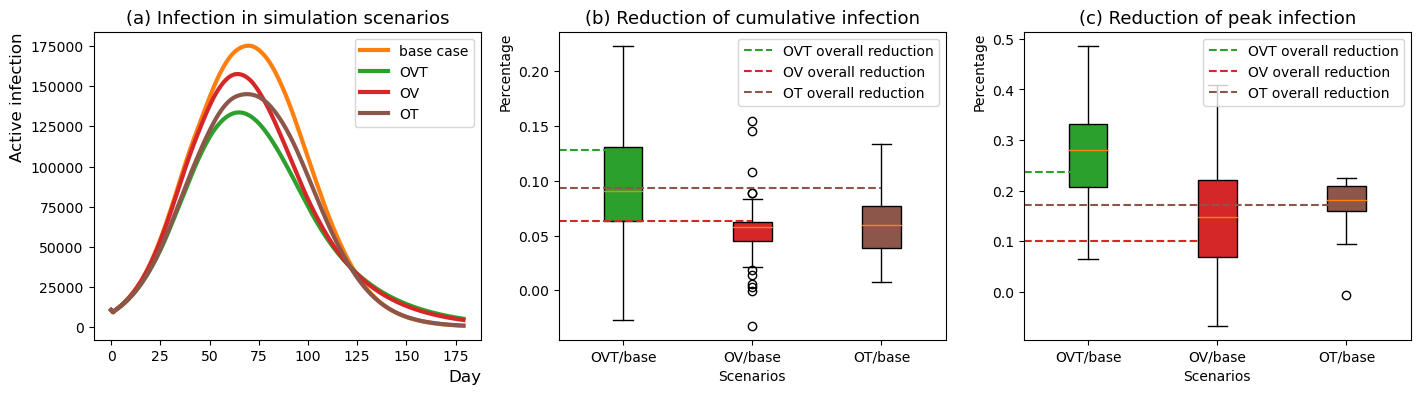

In [44]:


plt.figure(figsize=(17,4))

plt.subplot(1,3,1)
#plt.plot(Pref_covid['0'], linewidth = 2,label='real case')
plt.plot(C_inf0, linewidth = 3,label='base case',  color=pcolor['base'])
plt.plot(C_inf, linewidth = 3, label='OVT',  color=pcolor['OVT'])
plt.plot(C_inf_b, linewidth = 3, label='OV',  color=pcolor['OV'])
plt.plot(C_inf_d, linewidth = 3, label='OT',  color=pcolor['OT'])
plt.ylabel('Active infection', loc='top',fontsize = 12)
plt.xlabel('Day', loc='right',fontsize = 12)
plt.legend()
plt.title('(a) Infection in simulation scenarios', fontsize=13)

plt.subplot(1,3,2)
colors = [pcolor['OVT'], pcolor['OV'], pcolor['OT']]
for patch, color in zip(plt.boxplot([ovt_b, ov_b, ot_b], vert=True, patch_artist=True)['boxes'], colors):
    patch.set_facecolor(color)
#plt.boxplot([ovt_b, ov_b, ot_b], vert=True, ['lightblue', 'lightblue', 'lightblue'])
plt.xticks([1, 2, 3], ['OVT/base', 'OV/base', 'OT/base'])
plt.hlines (C_ovt, 0.5, 1.0, linestyle='--', color=pcolor['OVT'], label='OVT overall reduction')
plt.hlines (C_ov, 0.5, 2.0, linestyle='--', color=pcolor['OV'], label='OV overall reduction')
plt.hlines (C_ot, 0.5, 3.0, linestyle='--', color=pcolor['OT'],label='OT overall reduction')
plt.legend()
plt.xlabel('Scenarios')
plt.ylabel('Percentage', loc='top')
plt.title('(b) Reduction of cumulative infection', fontsize=13)


plt.subplot(1,3,3)
colors = [pcolor['OVT'], pcolor['OV'], pcolor['OT']]
for patch, color in zip(plt.boxplot([p_ovt_b, p_ov_b, p_ot_b], vert=True, patch_artist=True)['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1, 2, 3], ['OVT/base', 'OV/base', 'OT/base'])
plt.hlines (Cp_ovt, 0.5, 1.0, linestyle='--', color=pcolor['OVT'], label='OVT overall reduction')
plt.hlines (Cp_ov, 0.5, 2.0, linestyle='--', color=pcolor['OV'], label='OV overall reduction')
plt.hlines (Cp_ot, 0.5, 3.0, linestyle='--', color=pcolor['OT'],label='OT overall reduction')
plt.xlabel('Scenarios')
plt.ylabel('Percentage', loc='top')
plt.legend()
plt.title('(c) Reduction of peak infection', fontsize=13)

plt.subplots_adjust(wspace=0.2)
plt.show()

In [45]:
for i in range(len(ovt_b)):
    if ovt_b[i]<0:
        print(name[i+1], ovt_b[i])

Shimane -0.0240029012566286
Tokushima -0.02714101395361193


In [46]:
for i in range(len(ov_b)):
    if ov_b[i]<0:
        print(name[i+1], ov_b[i])

Shimane -0.00018091371584385627
Tokushima -0.032326213696186566


In [47]:
for i in range(len(p_ov_b)):
    if p_ov_b[i]<0:
        print(name[i+1], p_ov_b[i])

Akita -0.007744365279851604
Nagasaki -0.06139833094661268
Kumamoto -0.06670394655751817


In [48]:
for i in range(len(p_ot_b)):
    if p_ot_b[i]<0:
        print(name[i+1], p_ot_b[i])

Okinawa -0.0065026545158473744


In [49]:
cu_inf_d_ovt = {name[i]:ovt_b[i-1] for i in name}
cu_inf_d_ov = {name[i]:ov_b[i-1] for i in name}
cu_inf_d_ot = {name[i]:ot_b[i-1] for i in name}

p_inf_d_ovt = {name[i]:p_ovt_b[i-1] for i in name}
p_inf_d_ov = {name[i]:p_ov_b[i-1] for i in name}
p_inf_d_ot = {name[i]:p_ot_b[i-1] for i in name}

#### Total cost in real infection, vaccination and transportation

In [50]:
act_covid_path = '/Users/liuyang/Data/Covid data/Covid-actual.csv'

Pref_covid = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(act_covid_path, newline='') as cov_f:
    cov_reader = csv.reader(cov_f, delimiter= ' ', quotechar='|')
    next(cov_reader, None)
    for row in cov_reader:
        list_cov=row[0].split(',')
        Pref_covid[int(list_cov[0])] = [int(n) for n in list_cov[1:]]

In [51]:
#### calculate the cost in the real infection, vaccination and transportation control situation
cost_real = 0
for t in range(180):
    for j in N_p:
        cost_real += (c_i[j]*1000/N_p[j]*(Pref_covid[j][t])**2 + c_v*Vac_cnt[j][t] + c_b[j]*beta_a[j][t]**2)
    cost_real += c_d*(1-delta_a[t])**2 
print(cost_real)

32015428.092020743


#### Vaccination illustration by region

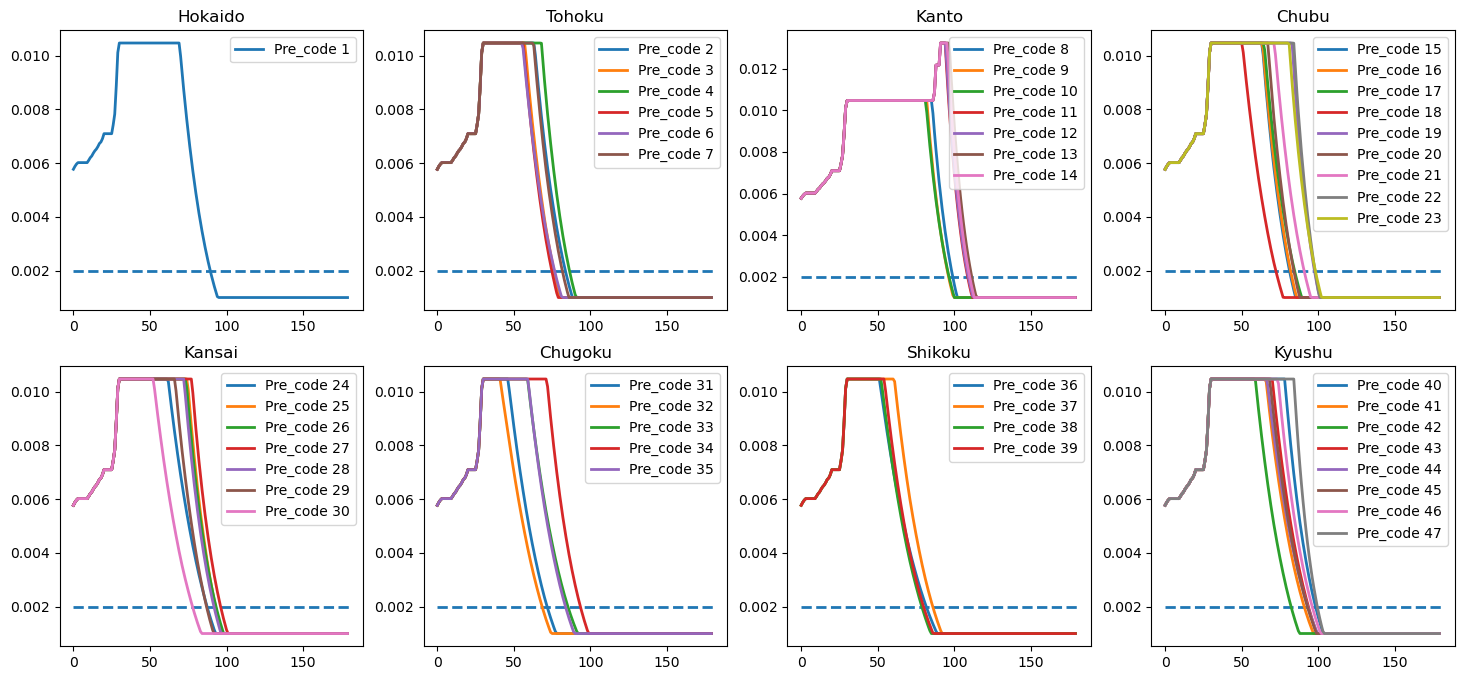

In [52]:
region = {'Hokaido':[1], 
          'Tohoku':[2, 3, 4, 5, 6, 7], 
          'Kanto':[8, 9, 10, 11, 12, 13, 14],
          'Chubu':[15, 16, 17, 18, 19, 20, 21, 22, 23],
          'Kansai':[24, 25, 26, 27, 28, 29, 30],
          'Chugoku':[31, 32, 33, 34, 35],
          'Shikoku':[36, 37, 38, 39],
          'Kyushu':[40, 41, 42, 43, 44, 45, 46, 47]}

plt.figure(figsize=(18,8))
i = 1
for n in region:
    plt.subplot(2,4,i)
    plt.hlines(0.002, 0, 180, linewidth = 2, linestyle='--')
    for pre in region[n]:
        plt.plot(beta_o[pre], linewidth = 2, label='Pre_code {0}'.format(pre))
    #plt.title(region_name[n], fontsize = 13)
    #plt.ylabel('Vaccination rate', loc='top', fontsize = 12)
    #plt.xlabel('day', loc='right', fontsize = 12)
    plt.legend(loc='best')
    plt.title(n)
    i+=1
plt.show()

#### Transport and Vaccine

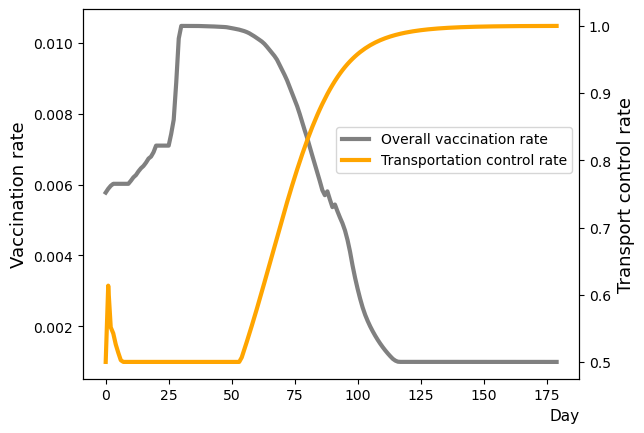

In [53]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(b_both, linewidth=3, color='grey', zorder=2.5,  label='Overall vaccination rate')
ax2.plot(delta_b, linewidth=3, color='orange',zorder=2.5, label='Transportation control rate')
ax2.set_axisbelow(True)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1, 0.7))
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc=0)
ax1.set_ylabel('Vaccination rate', fontsize=13)
ax2.set_ylabel('Transport control rate', fontsize=13)
ax1.set_xlabel('Day', fontsize=11, loc='right')
plt.show()

In [54]:
Vac_res_in = State_solution(N_p, N_0, sigma, X, kpa, Z, delta_o, beta_o, params)
R_inf_in, cost_in, L_s_in, L_v_in = Vac_res_in.get_res()


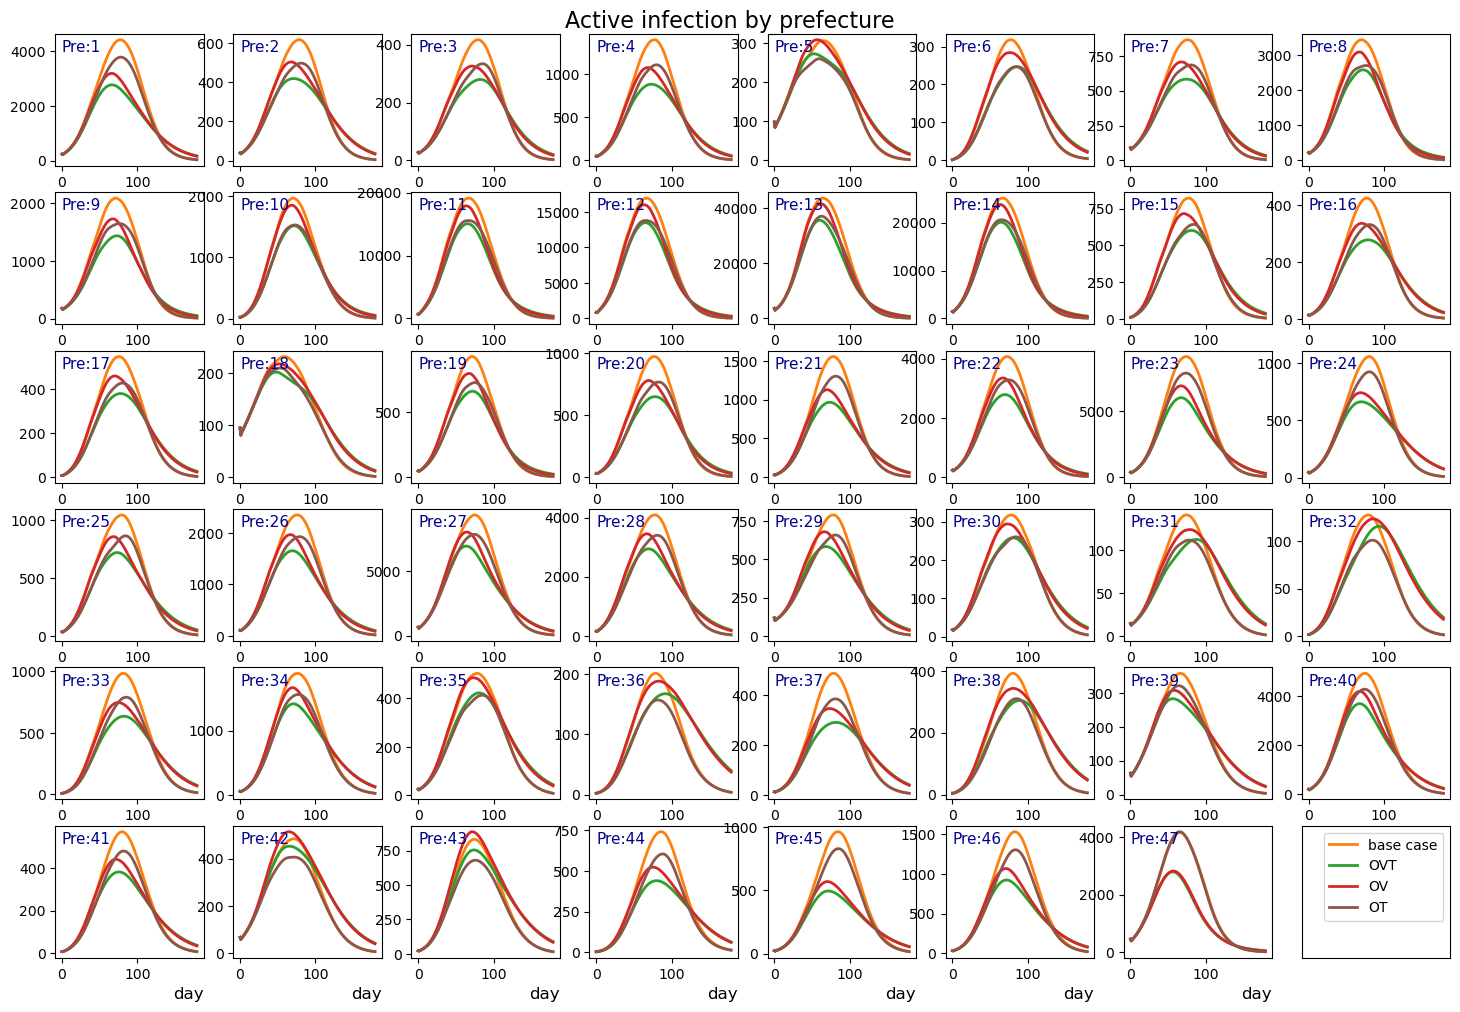

In [55]:
plt.figure(figsize=(18,12))
for n in Z[0]:
    plt.subplot(6,8,n)
    #plt.plot(R_inf0[n][3], linewidth = 2)
    plt.plot(R_inf0[n][3], linewidth = 2, label='base case', color=pcolor['base'])
    plt.plot(R_inf[n][3], linewidth = 2, label='OVT', color=pcolor['OVT'])
    plt.plot(R_inf_b[n][3], linewidth = 2, label='OV', color=pcolor['OV'])
    plt.plot(R_inf_d[n][3], linewidth = 2, label='OT', color=pcolor['OT'])
    #plt.plot(R_inf_in[n][3], linewidth = 2, label='OT', color='yellow')
    max_i = max(max(R_inf0[n][3]), max(R_inf[n][3]), max(R_inf_b[n][3]), max(R_inf_d[n][3]))
    plt.text(0, max_i*0.9, 'Pre:{0}'.format(n), color='darkblue', fontsize=11)
    #plt.title(region_name[n], fontsize = 13)
    #plt.ylabel('Active infected', loc='top',fontsize = 12)
    plt.xlabel('day', loc='right',fontsize = 12)
    #plt.legend()
plt.subplot(6,8,48)
plt.plot([], linewidth = 2, label='base case', color=pcolor['base'])
plt.plot([], linewidth = 2, label='OVT', color=pcolor['OVT'])
plt.plot([], linewidth = 2, label='OV', color=pcolor['OV'])
plt.plot([], linewidth = 2, label='OT', color=pcolor['OT'])
plt.xticks([])  # Hide x labels
plt.yticks([])  # Hide y labels
plt.legend()
plt.suptitle('Active infection by prefecture', fontsize=16, y=0.9)
plt.show()

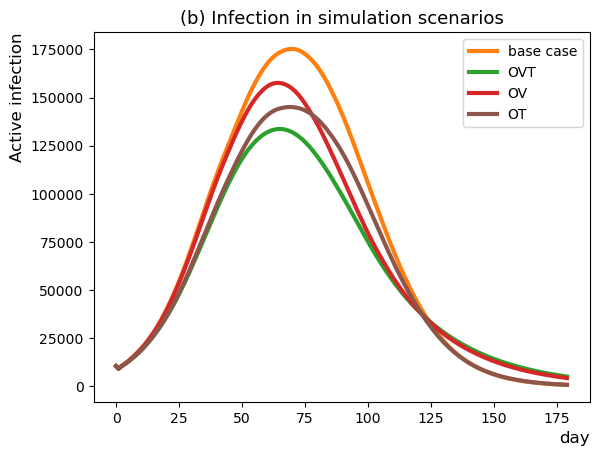

In [56]:
C_inf_in = [sum(R_inf_in[j][3][t] for j in N_0) for t in range(180)]

plt.plot(C_inf0, linewidth = 3,label='base case',  color=pcolor['base'])
plt.plot(C_inf, linewidth = 3, label='OVT',  color=pcolor['OVT'])
plt.plot(C_inf_b, linewidth = 3, label='OV',  color=pcolor['OV'])
plt.plot(C_inf_d, linewidth = 3, label='OT',  color=pcolor['OT'])
plt.ylabel('Active infection', loc='top',fontsize = 12)
plt.xlabel('day', loc='right',fontsize = 12)
plt.legend()
plt.title('(b) Infection in simulation scenarios', fontsize=13)
#plt.suptitle('Active infection', y=0.95, fontsize=13)
plt.show()

### Heat map

In [57]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


# Create a Graph
transportation_graph = nx.Graph()
for l in X:
    transportation_graph.add_edge(name[l[0]], name[l[1]], vol=X[l]/1000)


shapefile_path = 'gadm36_JPN_shp/gadm36_JPN_1.shp'
japan_map = gpd.read_file(shapefile_path)

# correct wrong names
japan_map.at[12, 'NAME_1'] = 'Hyogo'
japan_map.at[26, 'NAME_1'] = 'Nagasaki'

origins = set()
destinations = set()

for origin, destination in X.keys():
    origins.add(origin)
    destinations.add(destination)

num_origins = len(origins)
num_destinations = len(destinations)

heatmap_data = np.zeros((num_origins, num_destinations))

for (origin, destination), value in X.items():
    origin_idx = list(origins).index(origin)
    destination_idx = list(destinations).index(destination)
    heatmap_data[origin_idx, destination_idx] = value

# Create the heatmap


In [58]:
desname = [name[i] for i in destinations]
oriname = [name[i] for i in origins]

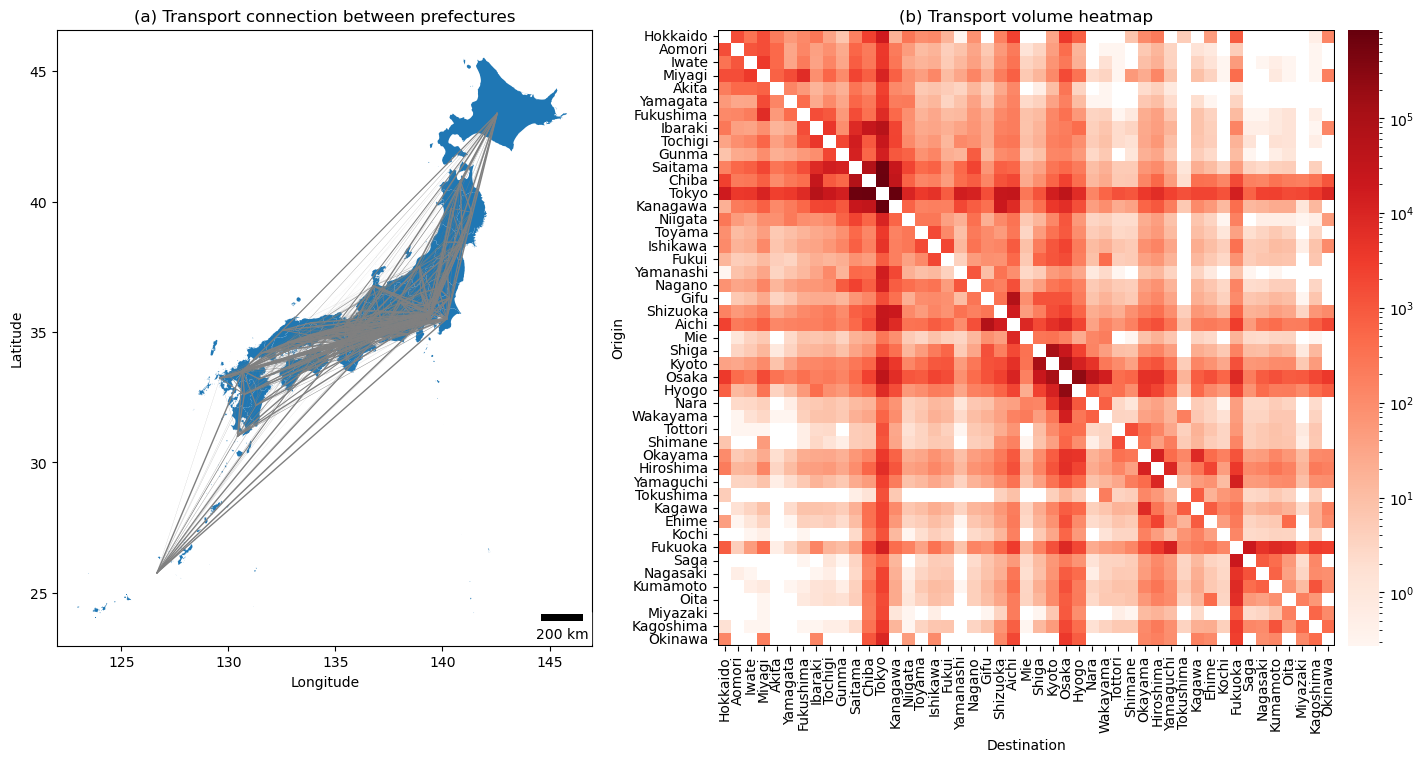

In [59]:
from matplotlib_scalebar.scalebar import ScaleBar
fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [4, 4]})


# Plot Japan Map
japan_map.plot(ax=axes[0])

# Plot Transportation Links
for edge in transportation_graph.edges(data=True):
    start, end, data = edge
    start_coords = japan_map[japan_map['NAME_1'] == start].geometry.iloc[0].centroid.coords[0]
    end_coords = japan_map[japan_map['NAME_1'] == end].geometry.iloc[0].centroid.coords[0]
    distance = data['vol']
    if distance > 0:
        if distance >= 1:
            axes[0].plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], color='grey', linewidth=1, alpha=1)
        else:
            axes[0].plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], color='grey', linewidth=distance, alpha=1)
axes[0].set_xlim(122, 147)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('(a) Transport connection between prefectures')
scalebar = ScaleBar(100, location='lower right', units='km', length_fraction=0.1)  # 创建一个比例尺，参数1表示1单位的地图距离
axes[0].add_artist(scalebar)

# Plot Heatmap
sns.heatmap(heatmap_data, annot=False, cmap='Reds', xticklabels=list(desname), yticklabels=list(oriname),
            norm=LogNorm(), cbar_kws=dict(location="right", anchor=(-0.3, 0)), ax=axes[1])

axes[1].set_xlabel('Destination')
axes[1].set_ylabel('Origin')
axes[1].set_title('(b) Transport volume heatmap')
axes[1].hlines(0, 0, 47.5, color='black')
axes[1].hlines(47, 0, 47.5, color='black')
axes[1].vlines(0, 0, 47.5, color='black')
axes[1].vlines(47, 0, 47.5, color='black')
axes[1].set_xticks(np.arange(0.5, 47.5, 1), minor=True)
axes[1].set_yticks(np.arange(0.5, 47.5, 1), minor=True)
# axes[1].grid(which="minor", color="black", linestyle='-', linewidth=2)
plt.subplots_adjust(wspace=0.01)
plt.show()


In [60]:
#japan_map.drop(['Percentage_ovt', 'Percentage_ov', 'Percentage_ot', 'Percentage_p_ov_x', 'Percentage_p_ov_y', 'Percentage_p_ov'], axis=1, inplace=True )

In [61]:
pop_cnt = {name[i]:N_p[i] for i in name}
trns_cnt = {name[i]:sum(X[l] for l in X if l[0]==i) for i in name}
trans_rate = {name[i]:sum(X[l] for l in X if l[0]==i)/N_p[i] for i in name}

pop_cnt_df = pd.DataFrame(list(pop_cnt.items()), columns=['Prefecture', 'pop_cnt'])
trns_cnt_df = pd.DataFrame(list(trns_cnt.items()), columns=['Prefecture', 'trns_cnt'])
trans_rate_df = pd.DataFrame(list(trans_rate.items()), columns=['Prefecture', 'trans_rate'])


In [62]:
percentage_df = pd.DataFrame(list(OVT_dict.items()), columns=['Prefecture', 'Percentage'])
japan_map1 = japan_map.merge(percentage_df, how='left', left_on='NAME_1', right_on='Prefecture')
jmap1 = japan_map1.merge(pop_cnt_df, how='left', left_on='NAME_1', right_on='Prefecture')
jmap1 = jmap1.merge(trns_cnt_df, how='left', left_on='NAME_1', right_on='Prefecture')
jmap1 = jmap1.merge(trans_rate_df, how='left', left_on='NAME_1', right_on='Prefecture')


/Users/liuyang/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1556: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Prefecture_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


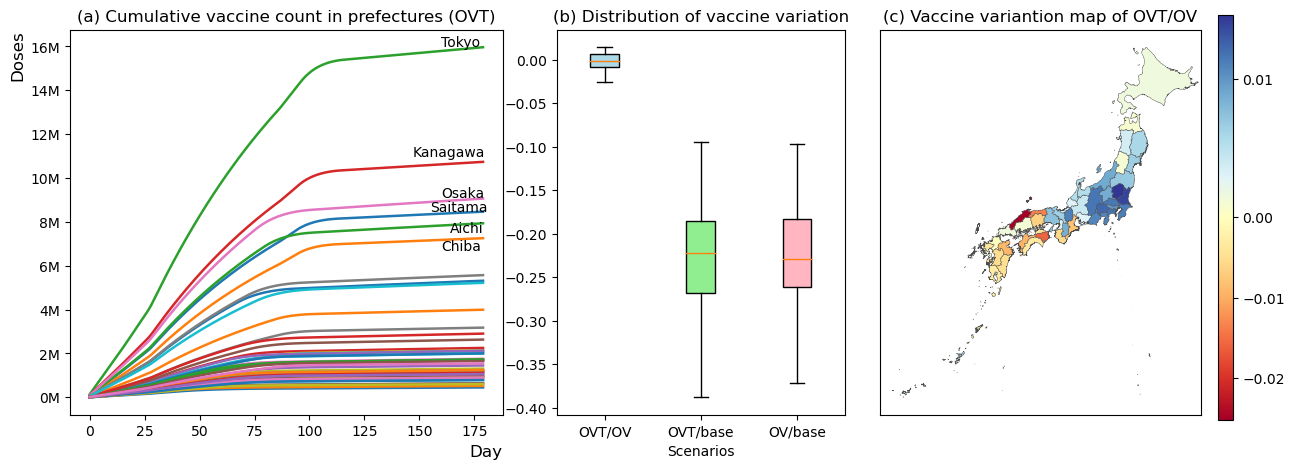

In [63]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib import gridspec
def format_ticks(value, pos):
    if value == max(Tloss_a):
        return '100M'
    else:
        return f'{value / 1e6:.0f}M'




fig = plt.figure(figsize=(15, 5))  # Set the overall figure size
gs = gridspec.GridSpec(1, 4, width_ratios=[1.8, 0.2, 1.2, 1.6])  # 1 row, 2 columns, width ratio 2:1

# Create subplots using gridspec
ax1 = plt.subplot(gs[0])  # The first subplot (wider)
ax2 = plt.subplot(gs[1])  # The second subplot (narrower)
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

for n in Z[0]:
    ax1.plot(Vac_cumu_ovt[n], linewidth = 1.8, label='OVT')
    #if Vac_cumu_ovt[n][-1] >0.6e7:
        #plt.text(180, Vac_cumu_ovt[n][-1]*0.99 , '{0}'.format(name[n]), color='black', fontsize=10)
    #plt.plot(Vac_cumu_ov[n], linewidth = 2, label='OV')
ax1.text(160, 1.6e7 , 'Tokyo', color='black', fontsize=10)
ax1.text(147, 1.1e7 , 'Kanagawa', color='black', fontsize=10)
ax1.text(160, 0.91e7 , 'Osaka', color='black', fontsize=10)
ax1.text(155, 0.85e7 , 'Saitama', color='black', fontsize=10)
ax1.text(164, 0.75e7 , 'Aichi', color='black', fontsize=10)
ax1.text(160, 0.67e7 , 'Chiba', color='black', fontsize=10)
#plt.axvspan(xmin=-15, xmax=5, ymin=0, ymax=1,linestyle='',color='grey', alpha=0.5)
ax1.set_xticks([0, 25, 50, 75, 100, 125, 150, 175], [0, 25, 50, 75, 100, 125, 150, 175])
ax1.set_title('(a) Cumulative vaccine count in prefectures (OVT)')
ax1.set_xlabel('Day', loc='right',fontsize = 12)
ax1.set_ylabel('Doses', loc='top',fontsize = 12)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))


ax2.axis('off')

colors = ['lightblue', 'lightgreen', 'lightpink']
#plt.boxplot([Vac_ovt_base, Vac_ov_base, Vac_ovt_ov], vert=False, patch_artist=True, widths=0.4)
# Customize the box colors
for patch, color in zip(ax3.boxplot([Vac_ovt_ov, Vac_ovt_base, Vac_ov_base], vert=True, patch_artist=True)['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
ax3.set_xticks([1, 2, 3], [ 'OVT/OV', 'OVT/base', 'OV/base'])
ax3.set_xlabel('Scenarios')
ax3.set_title('(b) Distribution of vaccine variation')



cmap = plt.get_cmap('RdYlBu')
im = jmap1.plot(column='Percentage', cmap=cmap, ax=ax4, linewidth=0.3, edgecolor='0.3')
ax4.set_xlim(122, 146)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('(c) Vaccine variantion map of OVT/OV')


norm = TwoSlopeNorm(vcenter=0, vmin=jmap1['Percentage'].min(), vmax=jmap1['Percentage'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.89, 0.1, 0.01, 0.81])  # [x, y, width, height]
cbar = fig.colorbar(sm,  cax=cbar_ax, orientation='vertical', shrink=[0.5, 1.5])
tick_values = [-0.02,-0.01, 0, 0.01]  
cbar.set_ticks(tick_values)


# Show the plot

plt.subplots_adjust(wspace=0.01)
plt.show()

In [64]:
# make dict for cumulative/peak infection reduction for each prefecture
cu_inf_d_ovt = {name[i]:ovt_b[i-1] for i in name}
cu_inf_d_ov = {name[i]:ov_b[i-1] for i in name}
cu_inf_d_ot = {name[i]:ot_b[i-1] for i in name}
p_inf_d_ov = {name[i]:p_ov_b[i-1] for i in name}

In [65]:
from matplotlib.colors import TwoSlopeNorm

# convert dict to df to merge to map data
cu_ovt_df = pd.DataFrame(list(cu_inf_d_ovt.items()), columns=['Prefecture', 'Percentage_ovt'])
cu_ov_df = pd.DataFrame(list(cu_inf_d_ov.items()), columns=['Prefecture', 'Percentage_ov'])
cu_ot_df = pd.DataFrame(list(cu_inf_d_ot.items()), columns=['Prefecture', 'Percentage_ot'])
p_ov_df = pd.DataFrame(list(p_inf_d_ov.items()), columns=['Prefecture', 'Percentage_p_ov'])
japan_map = japan_map.merge(cu_ovt_df, how='left', left_on='NAME_1', right_on='Prefecture')
japan_map = japan_map.merge(cu_ov_df, how='left', left_on='NAME_1', right_on='Prefecture')
japan_map = japan_map.merge(cu_ot_df, how='left', left_on='NAME_1', right_on='Prefecture')
japan_map = japan_map.merge(p_ov_df, how='left', left_on='NAME_1', right_on='Prefecture')

/Users/liuyang/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1556: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Prefecture_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


In [66]:
p_inf_d_ovt = {name[i]:p_ovt_b[i-1] for i in name}
p_inf_d_ot = {name[i]:p_ot_b[i-1] for i in name}

p_ovt_df = pd.DataFrame(list(p_inf_d_ovt.items()), columns=['Prefecture', 'Percentage_p_ovt'])
p_ot_df = pd.DataFrame(list(p_inf_d_ot.items()), columns=['Prefecture', 'Percentage_p_ot'])

japan_map = japan_map.merge(p_ovt_df, how='left', left_on='NAME_1', right_on='Prefecture')

japan_map = japan_map.merge(p_ot_df, how='left', left_on='NAME_1', right_on='Prefecture')


/Users/liuyang/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1556: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Prefecture_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


In [67]:
# box data for cumulative infection reduction
print(np.percentile(ovt_b, 0), np.percentile(ovt_b, 100))
print(np.percentile(ov_b, 0), np.percentile(ov_b, 100))
print(np.percentile(ot_b, 0), np.percentile(ot_b, 100))

-0.02714101395361193 0.22335478923598426
-0.032326213696186566 0.15433874120055777
0.0077409765458786185 0.13358998912515113


In [68]:
# box data for peak infection reduction
print(np.percentile(p_ovt_b, 0), np.percentile(p_ovt_b, 100))
print(np.percentile(p_ov_b, 0), np.percentile(p_ov_b, 100))
print(np.percentile(p_ot_b, 0), np.percentile(p_ot_b, 100))

0.06509544885401207 0.4863954216555719
-0.06670394655751817 0.4092475685098757
-0.0065026545158473744 0.22520572163286925


In [69]:
japan_map.drop(['Prefecture_y', 'Prefecture_x'], axis=1, inplace=True )

In [70]:
japan_map['Percentage_ovt'].max()

0.22335478923598426

In [71]:
japan_map['Percentage_ov'].min()

-0.032326213696186566

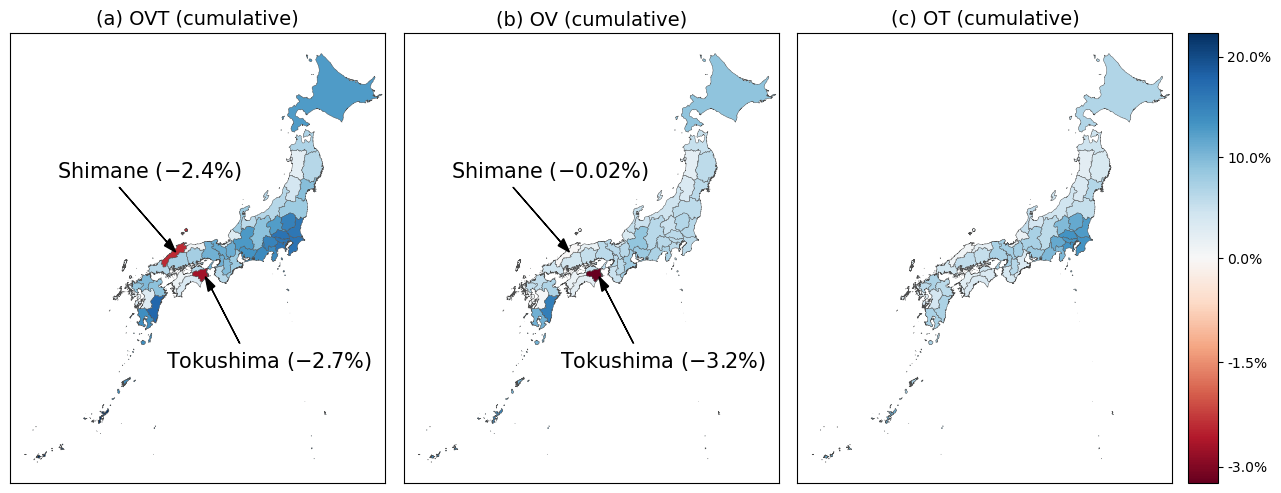

In [72]:
# Map of cumulative infection reduction by prefectures

import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
cmap = plt.get_cmap('RdBu')
norm = TwoSlopeNorm(vcenter=0, vmin=japan_map['Percentage_ov'].min(), vmax=japan_map['Percentage_ovt'].max())
japan_map.plot(column='Percentage_ovt', cmap=cmap, norm=norm, linewidth=0.3, ax=axes[0], edgecolor='0.3')
japan_map.plot(column='Percentage_ov', cmap=cmap, norm=norm, linewidth=0.3, ax=axes[1], edgecolor='0.3')
japan_map.plot(column='Percentage_ot', cmap=cmap, norm=norm, linewidth=0.3, ax=axes[2], edgecolor='0.3')

#
#ax.set_title('Heatmap of cumulative infection reduction of OVT to base', fontsize=16)
axes[0].set_xlim(122, 146)
axes[1].set_xlim(122, 146)
axes[2].set_xlim(122, 146)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.91, 0.12, 0.02, 0.75])  # [x, y, width, height]

cbar = fig.colorbar(sm,  cax=cbar_ax, orientation='vertical', shrink=0.5)
tick_values = [-0.03,-0.015, 0,0.1, 0.2]  

cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{val:.1%}' for val in tick_values]) 


#for ax in axes:
#    ax.set_xticks([])
#    ax.set_yticks([])

axes[0].set_title('(a) OVT (cumulative)', fontsize=14, y=1)
axes[1].set_title('(b) OV (cumulative)', fontsize=14, y=1)
axes[2].set_title('(c) OT (cumulative)', fontsize=14, y=1)


arrow_props = dict( color='black') 
axes[0].text(125, 39, "Shimane ($-2.4\%$)", fontsize=15, color='Black')
axes[0].arrow(129, 38.5, 3.6,-3.4,head_width=0.5,length_includes_head=True, **arrow_props)

axes[0].text(132, 29, "Tokushima ($-2.7\%$)", fontsize=15, color='Black')
axes[0].arrow(136.7, 30.3, -2.2,3.5,head_width=0.5,length_includes_head=True, **arrow_props)


axes[1].text(125, 39, "Shimane ($-0.02\%$)", fontsize=15, color='Black')
axes[1].arrow(129, 38.5, 3.6,-3.4,head_width=0.5,length_includes_head=True, **arrow_props)

axes[1].text(132, 29, "Tokushima ($-3.2\%$)", fontsize=15, color='Black')
axes[1].arrow(136.7, 30.3, -2.2,3.5,head_width=0.5,length_includes_head=True, **arrow_props)



axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[2].set_xticks([])
axes[2].set_yticks([])


plt.subplots_adjust(wspace=0.05)
plt.show()


In [73]:
japan_map['Percentage_p_ov'].min()

-0.06670394655751817

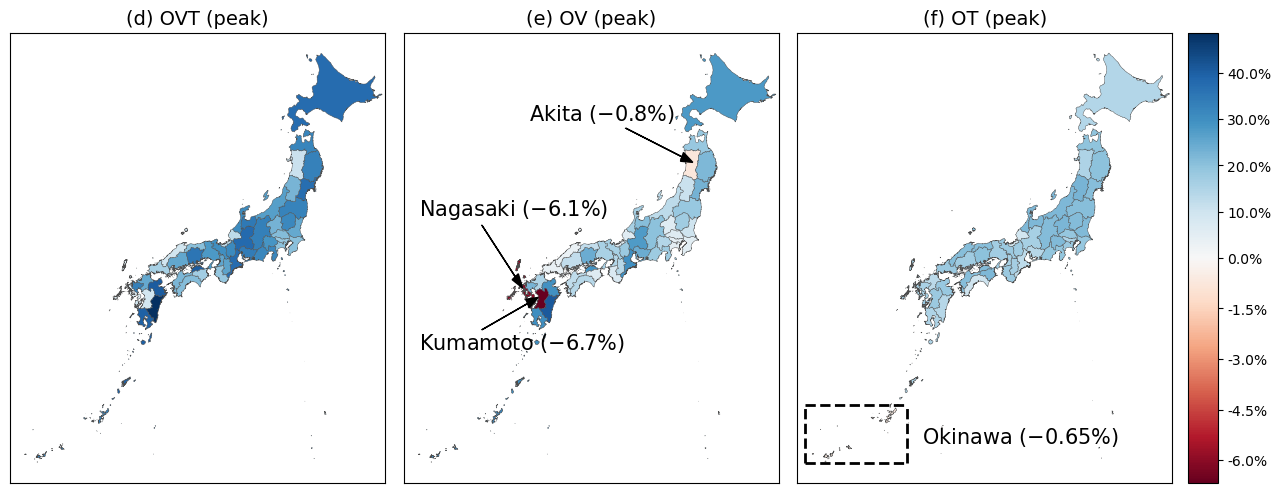

In [74]:
# Map of peak infection reduction by prefectures

import geopandas as gpd

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
cmap = plt.get_cmap('RdBu')
#norm = TwoSlopeNorm(vcenter=0, vmin=japan_map['Percentage_ov'].min(), vmax=japan_map['Percentage_ovt'].max())
norm = TwoSlopeNorm(vcenter=0, vmin=japan_map['Percentage_p_ov'].min(), vmax=japan_map['Percentage_p_ovt'].max())
japan_map.plot(column='Percentage_p_ovt', cmap=cmap, norm=norm, linewidth=0.3, ax=axes[0], edgecolor='0.3')
japan_map.plot(column='Percentage_p_ov', cmap=cmap, norm=norm, linewidth=0.3, ax=axes[1], edgecolor='0.3')
japan_map.plot(column='Percentage_p_ot', cmap=cmap, norm=norm, linewidth=0.3, ax=axes[2], edgecolor='0.3')
#
#ax.set_title('Heatmap of cumulative infection reduction of OVT to base', fontsize=16)
axes[0].set_xlim(122, 146)
axes[1].set_xlim(122, 146)
axes[2].set_xlim(122, 146)


# Add colorbar
#cbar = fig.colorbar(japan_map4, ax=axes, orientation='vertical',norm=norm, fraction=0.015, pad=0.03)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.91, 0.12, 0.02, 0.75])  # [x, y, width, height]

cbar = fig.colorbar(sm,  cax=cbar_ax, orientation='vertical', shrink=[0.5, 1.5])
tick_values = [-0.06,-0.045,-0.03,-0.015, 0, 0.1, 0.2, 0.3, 0.4]  

cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{val:.1%}' for val in tick_values]) 


#for ax in axes:
#    ax.set_xticks([])
#    ax.set_yticks([])


axes[0].set_title('(d) OVT (peak)', fontsize=14, y=1)
axes[1].set_title('(e) OV (peak)', fontsize=14, y=1)
axes[2].set_title('(f) OT (peak)', fontsize=14, y=1)





axes[1].text(123, 37, "Nagasaki ($-6.1\%$)", fontsize=15, color='Black')
axes[1].arrow(127, 36.5, 2.6,-3.3,head_width=0.5,length_includes_head=True, **arrow_props)
axes[1].text(123, 30, "Kumamoto ($-6.7\%$)", fontsize=15, color='Black')
axes[1].arrow(127, 31, 3.6, 1.7,head_width=0.5,length_includes_head=True, **arrow_props)
axes[1].text(130, 42, "Akita ($-0.8\%$)", fontsize=15, color='Black')
axes[1].arrow(136.2, 41.6, 4.3, -1.8,head_width=0.5,length_includes_head=True, **arrow_props)


axes[2].vlines(129, 24, 27,colors='black', linestyles='dashed', linewidth=2 )
axes[2].vlines(122.5, 24, 27,colors='black', linestyles='dashed', linewidth=2 )
axes[2].hlines(24, 122.5, 129,colors='black', linestyles='dashed', linewidth=2 )
axes[2].hlines(27, 122.5, 129,colors='black', linestyles='dashed', linewidth=2 )
axes[2].text(130, 25, "Okinawa ($-0.65\%$)", fontsize=15, color='Black')


axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[2].set_xticks([])
axes[2].set_yticks([])


plt.subplots_adjust(wspace=0.05)
plt.show()
